In [71]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.optimize import curve_fit
import pandas as pd
import pyhf
from scipy.special import expit

root_dir = "/Users/user/PhD/HPS_uboone_analysis/"
root_dir_fixed = root_dir

# Calculating CL $_s$

Using using the implementation outlined in [The Gaussian CLs Method for Searches of New Physics](https://arxiv.org/abs/1407.5052)

In [72]:
def T_h(N, mu):
    """
    N = observed events / asiimov data
    mu = expected events
    """

    # Poisson distribution
    return 2*np.sum(mu - N + N*np.log(N/mu))

    # # Gaussian distribution
    # return np.sum( np.log(mu/N) + np.sum((N-mu)**2/mu) )

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def calculate_cls(h0, h1, bins, threshold):
    if len(h0) != len(h1):
        raise ValueError("h0 and h1 must have the same length")
    
    if len(h0) == len(bins):
        None
    elif len(h0) + 1 == len(bins):
        bins = bins[:-1]
    else:
        raise ValueError("h0 and h1 must have the same length as bins or bins+1")

    p_b = np.sum(h0[bins > threshold]) / np.sum(h0)
    p_sb = np.sum(h1[bins > threshold]) / np.sum(h1)
    return p_sb / (1-p_b)

def get_limit(mu, cls_vals, alpha):
    """
    Given mu, cls_vals and alpha.
    Returns the limit for the given alpha.
    """
    try:
        lim = mu[np.where(cls_vals < alpha)[0][0]]
    except IndexError:
        lim = np.nan
    return lim

def get_obs_exp_cls(obs, s, s_uncert, b, b_uncert, n_uni=1000, plot_test_hist=False):
    """
    Generate expected CLS values for a given signal and background.
    """
    h0_arr = []
    h1_arr = []
    for i in range(n_uni):
        h1_asi = np.random.normal(loc=s+b, scale=np.sqrt(s_uncert**2 + b_uncert**2))
        h0_asi = np.random.normal(loc=b, scale=b_uncert)

        deltaT_h0 = T_h(h0_asi, s+b) - T_h(h0_asi, b)
        deltaT_h1 = T_h(h1_asi, s+b) - T_h(h1_asi, b)

        h0_arr.append(deltaT_h0)
        h1_arr.append(deltaT_h1)

    deltaT_obs = T_h(obs, s+b) - T_h(obs, b)
    h0_arr = np.array(h0_arr)
    h0_arr = h0_arr[~np.isnan(h0_arr)]

    h1_arr = np.array(h1_arr)
    h1_arr = h1_arr[~np.isnan(h1_arr)]

    lo_T = np.min([np.min(h0_arr), np.min(h1_arr)])
    hi_T = np.max([np.max(h0_arr), np.max(h1_arr)])

    hist_bins = np.linspace(lo_T, hi_T, 100)
    hist_h0, _ = np.histogram(h0_arr, bins=hist_bins, density=True)
    hist_h1, _ = np.histogram(h1_arr, bins=hist_bins, density=True)

    # Fit a Gaussian to the h0 distribution to extract the std of the distribution
    A_start = np.max(hist_h0)
    H_start = np.median(h0_arr)
    bin_centers = 0.5*(hist_bins[1:] + hist_bins[:-1])
    parameters, covariance = curve_fit(gauss, bin_centers, hist_h0, p0=[A_start, H_start, np.std(h0_arr)], maxfev=10000)

    A, x0, sigma = parameters

    cls_obs = calculate_cls(hist_h0, hist_h1, hist_bins, deltaT_obs)
    cls_exp = calculate_cls(hist_h0, hist_h1, hist_bins, x0)
    cls_exp_1up = calculate_cls(hist_h0, hist_h1, hist_bins, x0 + sigma)
    cls_exp_1down = calculate_cls(hist_h0, hist_h1, hist_bins, x0 - sigma)
    cls_exp_2up = calculate_cls(hist_h0, hist_h1, hist_bins, x0 + 2*sigma)
    cls_exp_2down = calculate_cls(hist_h0, hist_h1, hist_bins, x0 - 2*sigma)

    if plot_test_hist:
        plt.figure(figsize=(10, 6))
        plt.hist(h0_arr, bins=hist_bins, density=True, alpha=0.5, label='h0')
        plt.hist(h1_arr, bins=hist_bins, density=True, alpha=0.5, label='h1')
        plt.axvline(x=deltaT_obs, color='r', linestyle='--', label='Observed')
        plt.axvline(x=x0, color='g', linestyle='--', label='Expected')
        plt.axvline(x=x0 + sigma, color='b', linestyle='--', label='Expected + 1 sigma')
        plt.axvline(x=x0 - sigma, color='b', linestyle='--', label='Expected - 1 sigma')
        plt.axvline(x=x0 + 2*sigma, color='c', linestyle='--', label='Expected + 2 sigma')
        plt.axvline(x=x0 - 2*sigma, color='c', linestyle='--', label='Expected - 2 sigma')
    
        plt.legend()
        plt.xlabel('Test Statistic')
        plt.ylabel('Density')
        plt.title('Test Statistic Distribution')
        plt.show()
    return cls_obs, cls_exp, cls_exp_1up, cls_exp_1down, cls_exp_2up, cls_exp_2down

In [73]:
def get_cls(obs, s, s_uncert, b, b_uncert, n_uni=10000, show_hist=False, is_exp=False):
    h0_arr = []
    h1_arr = []
    for i in range(n_uni):
        h1_asi = np.random.normal(loc=s+b, scale=np.sqrt(s_uncert**2 + b_uncert**2))
        h0_asi = np.random.normal(loc=b, scale=b_uncert)

        deltaT_h0 = T_h(h0_asi, s+b) - T_h(h0_asi, b)
        deltaT_h1 = T_h(h1_asi, s+b) - T_h(h1_asi, b)

        h0_arr.append(deltaT_h0)
        h1_arr.append(deltaT_h1)
    
    deltaT_obs = T_h(obs, s+b) - T_h(obs, b)
    h0_arr = np.array(h0_arr)
    h0_arr = h0_arr[~np.isnan(h0_arr)]

    h1_arr = np.array(h1_arr)
    h1_arr = h1_arr[~np.isnan(h1_arr)]

    lo_T = np.min([np.min(h0_arr), np.min(h1_arr)])
    hi_T = np.max([np.max(h0_arr), np.max(h1_arr)])

    hist_bins = np.linspace(lo_T, hi_T, 100)
    hist_h0, _ = np.histogram(h0_arr, bins=hist_bins, density=True)
    hist_h1, _ = np.histogram(h1_arr, bins=hist_bins, density=True)

    p1 = np.sum(hist_h1[hist_bins[:-1] > deltaT_obs]) / np.sum(hist_h1)
    p0 = np.sum(hist_h0[hist_bins[:-1] < deltaT_obs]) / np.sum(hist_h0)

    if show_hist:
        bin_centers = 0.5*(hist_bins[1:] + hist_bins[:-1])
        plt.figure(figsize=(10, 6))
        if is_exp:
            A_start = np.max(hist_h0)
            H_start = np.median(h0_arr)
            parameters, covariance = curve_fit(gauss, bin_centers, hist_h0, p0=[A_start, H_start, np.std(h0_arr)], maxfev=10000)
            plt.plot(bin_centers, gauss(bin_centers, *parameters), label='Gaussian fit', color='red')
            plt.axvline(parameters[1] + parameters[2], color='red', linestyle='--', label='Gaussian fit + sigma')
            plt.axvline(parameters[1] - parameters[2], color='red', linestyle='--', label='Gaussian fit - sigma')
            plt.axvline(parameters[1], color='blue', linestyle='--', label='Gaussian fit mean')
        plt.stairs(hist_h0, hist_bins, label='H0', color='blue', alpha=0.5)
        plt.fill_betweenx(np.append(hist_h0, hist_h0[-1]), hist_bins, deltaT_obs, where=hist_bins < deltaT_obs, step='pre', color='blue', label=p0, alpha=0.5)
        plt.stairs(hist_h1, hist_bins, label='H1', color='orange', alpha=0.5)
        plt.fill_betweenx(np.append(hist_h1, hist_h1[-1]), hist_bins, deltaT_obs, where=hist_bins > deltaT_obs, step='pre', color='orange', label=p1, alpha=0.5)
        plt.axvline(deltaT_obs, color='r', linestyle='--', label='Observed')
        plt.xlabel(r'$\Delta$ T = T$_H$$_1$ - T$_H$$_0$')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    if is_exp:

        bin_centers = 0.5*(hist_bins[1:] + hist_bins[:-1])
        A_start = np.max(hist_h0)
        H_start = np.median(h0_arr)
        parameters, covariance = curve_fit(gauss, bin_centers, hist_h1, p0=[A_start, H_start, np.std(h0_arr)], maxfev=10000)

        sigma_up = parameters[1] + parameters[2]
        sigma_down = parameters[1] - parameters[2]

        cls_exp = p1 / (1 - p0)
        print()
        print(f"p1: {p1}, p0: {p0}, cls: {cls_exp}")
        p1 = np.sum(hist_h1[hist_bins[:-1] > sigma_up]) / np.sum(hist_h1)
        p0 = np.sum(hist_h0[hist_bins[:-1] < sigma_up]) / np.sum(hist_h0)
        cls_exp_up = p1 / (1 - p0)
        print(f"p1: {p1}, p0: {p0}, cls: {cls_exp_up}")
        p1 = np.sum(hist_h1[hist_bins[:-1] > sigma_down]) / np.sum(hist_h1)
        p0 = np.sum(hist_h0[hist_bins[:-1] < sigma_down]) / np.sum(hist_h0)
        cls_exp_down = p1 / (1 - p0)
        print(f"p1: {p1}, p0: {p0}, cls: {cls_exp_down}")
        return cls_exp, cls_exp_up, cls_exp_down

    else:
        return p1 / (1-p0)

def hist_prep(hist):
    """
    Replacing zero bins with 1e-10
    """
    hist = np.array(hist)
    hist[hist <= 0] = 1e-10
    return hist

# Using old hist loader

In [74]:
Params_pyhf = {"Stats_only":False,
               "Use_flat_sys":False,
               "Num_bins_for_calc":6,
               "Use_part_only":True,
               "Use_toys":False,
               "Num_toys":1000,
               "POT_scaling": 1.0, #  1.0,
               "Flat_bkg_overlay_frac":0.3,
               "Flat_bkg_dirt_frac":0.75,
               "Flat_bkg_EXT_frac":0.0,
               "Flat_sig_detvar":0.2, 
               "Scale_bkg_neutrino_flux": 1., # Scaling dirt and overlay fluxes
               "Scale_signal_flux": 1., # Scaling signal flux
               "Scale_kdar_signal_flux": 1., # Scaling signal flux from KDARs only
               "Scale_flux_uncertainty": 1., 
               "Signal_flux_error":0.3,
               "Overlay_detvar_frac":0.3,
               "Load_single_r1_file":False}

def New_Load_pyhf_files(filenames, location=root_dir+'BDT_output/',HNL_masses=[100, 150, 200]):
    loc_hists = location

    hist_dict_run1, hist_dict_run3, theta_dict = {}, {}, {}

    #Loading in the .root files
    for HNL_mass in HNL_masses:
        for shr in ["1shr", "2shr"]:
            for K in ["KDIF", "KDAR"]:
                name_ends = f"{HNL_mass}_{shr}_{K}"
                hist_dict_run1[name_ends] = uproot.open(loc_hists+f'run1_ALL_Capped_{name_ends}' + filenames)
                hist_dict_run3[name_ends] = uproot.open(loc_hists+f'run3_ALL_Capped_{name_ends}' + filenames)

                theta_dict[HNL_mass] = hist_dict_run1[name_ends]["theta"].values()[0] #assuming scaled theta is the same for all runs, only 1 value saved

    all_hists_list = ['bkg_overlay;1', 'bkg_dirt;1', 'bkg_EXT;1', 'signal;1', 'data;1', 'theta;1',  
                      'ppfx_uncertainty_frac;1', 'Genie_uncertainty_frac;1', 'Reinteraction_uncertainty_frac;1', 
                      'overlay_DetVar_uncertainty_frac;1', 'signal_DetVar_uncertainty_frac;1', "signal_KDAR_frac;1"]
    missing_hists = []
    for hist_name in all_hists_list:
        if hist_name not in hist_dict_run1[name_ends].keys(): missing_hists.append(hist_name)
    if len(missing_hists) == 0: print("No missing histograms in Run1")
    else:
        print("Missing hists for Run1 are: ")
        print(missing_hists)

    for hist_name in all_hists_list:
        if hist_name not in hist_dict_run3[name_ends].keys(): missing_hists.append(hist_name)
    if len(missing_hists) == 0: print("No missing histograms in Run3")
    else:
        print("Missing hists for Run3 are: ")
        print(missing_hists)

    print(theta_dict)
    print("Done")
    
    return hist_dict_run1, hist_dict_run3, theta_dict


In [75]:
all_HPS_masses = [100, 125, 130, 135, 140, 145, 150, 200]


c_phi_dict  = {
				100:	0.0027014149387605906, 
				125: 	0.0018106609327994778, 
                130:	0.0009990304425688081, 
                135:	4.52690931768051e-06, 
                140:	0.0008568518547569688, 
                145:	0.0014326989318147938, 
                150:	0.001798938228520414, 
                200:	0.002864767955135017
				}  


# Retrieving BDT scores from either reweighted or HPS directory


hist_dict_run1, hist_dict_run3, theta_dict = New_Load_pyhf_files(f".root", location=root_dir+"BDT_output/", HNL_masses=all_HPS_masses)

No missing histograms in Run1
No missing histograms in Run3
{100: 0.000536, 125: 0.00055, 130: 0.000554, 135: 0.000558, 140: 0.000563, 145: 0.000568, 150: 0.000573, 200: 0.000658}
Done


In [76]:
def add_hists_vals(hist_list):
    Total_hist = np.zeros_like(hist_list[0])
    for hist in hist_list:
        Total_hist += hist
    return Total_hist

def add_all_errors_dict(err_dict): #adds in quadrature, assuming all hists are same shape
    list_keys = list(err_dict.keys())
    Total_hist = np.zeros_like(err_dict[list_keys[0]])
    for i in range(len(err_dict[list_keys[0]])): #Looping over the bins
        for errs in err_dict.keys(): #Looping over the histograms
            Total_hist[i] += err_dict[errs][i]**2 #Adding error from each hist in quadrature
        Total_hist[i] = np.sqrt(Total_hist[i])
    return Total_hist

def add_all_errors(err_list): #adds in quadrature, assuming all hists are same shape
    Total_hist = np.zeros_like(err_list[0])
    for i in range(len(err_list[0])): #Looping over the bins
        for errs in err_list: #Looping over the histograms
            Total_hist[i] += errs[i]**2 #Adding error from each hist in quadrature
        Total_hist[i] = np.sqrt(Total_hist[i])
    return Total_hist

def Full_calculate_total_uncertainty(Params, hist_dict, zero_bins_errs): #Takes the dictionary of all root files
    """
    Given parameters, hist dict and zero bins error.
    Returns a dict of all types of error and individual sample values for use in models.
    """
    OVERLAY_VALS, DIRT_VALS, BEAMOFF_VALS = {}, {}, {}
    OVERLAY_STAT, DIRT_STAT, BEAMOFF_STAT = {}, {}, {}
    TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict = {}, {}
    BKG_STAT_ERR_dict, SIGNAL_STAT_ERR_dict = {}, {}
    BKG_DETVAR_ERR_dict, BKG_DIRT_ERR_dict, BKG_MULTISIM_ERR_dict = {}, {}, {}
    BKG_SHAPESYS_ERR_dict, SIGNAL_SHAPESYS_ERR_dict = {}, {}
    BKG_DETVAR_MULTISIM_dict = {}
    SIGNAL_DETVAR_ERR_dict = {}
    SIGNAL_NORMSYS_ERR_dict = {} #No normsys for this because currently background contributions are added together
    bkg_sample_names = ['bkg_overlay','bkg_EXT','bkg_dirt']
    overlay_sys_frac_flux = "ppfx_uncertainty_frac"
    overlay_sys_frac_names = ["Genie_uncertainty_frac","Reinteraction_uncertainty_frac","overlay_DetVar_uncertainty_frac"]
    for HNL_mass in hist_dict:
        bkg_stat_err_dict, bkg_sys_err_dict = {}, {} #Clean for each mass point
        
        OVERLAY_VALS[HNL_mass] = hist_dict[HNL_mass]['bkg_overlay'].values() * Params["Scale_bkg_neutrino_flux"] * Params["POT_scaling"]
        DIRT_VALS[HNL_mass] = hist_dict[HNL_mass]['bkg_dirt'].values() * Params["Scale_bkg_neutrino_flux"] * Params["POT_scaling"]
        BEAMOFF_VALS[HNL_mass] = hist_dict[HNL_mass]['bkg_EXT'].values() * Params["POT_scaling"]
        OVERLAY_STAT[HNL_mass] = np.add(hist_dict[HNL_mass]['bkg_overlay'].errors(), zero_bins_errs[HNL_mass]['bkg_overlay'])
        DIRT_STAT[HNL_mass] = np.add(hist_dict[HNL_mass]['bkg_dirt'].errors(), zero_bins_errs[HNL_mass]['bkg_dirt'])
        BEAMOFF_STAT[HNL_mass] = np.add(hist_dict[HNL_mass]['bkg_EXT'].errors(), zero_bins_errs[HNL_mass]['bkg_EXT'])
        
        for name in bkg_sample_names:
            bkg_stat_err_dict[name]=np.add(hist_dict[HNL_mass][name].errors(), zero_bins_errs[HNL_mass][name])
        sig_stat_err = np.add(hist_dict[HNL_mass]['signal'].errors(), zero_bins_errs[HNL_mass]['signal'])
        
        if Params["Stats_only"] == True: #Set all systematic errors to zero
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = np.zeros_like(hist_dict[HNL_mass][name].errors())

            overlay_sys_dict = {}

            overlay_sys_dict[overlay_sys_frac_flux] = np.zeros_like(hist_dict[HNL_mass][overlay_sys_frac_flux].values())
                  
            for sys in overlay_sys_frac_names:
                overlay_sys_dict[sys] = np.zeros_like(hist_dict[HNL_mass][sys].values())

            sig_sys_err =  np.zeros_like(hist_dict[HNL_mass]['signal'].errors())
            sig_detvar_err = np.zeros_like(hist_dict[HNL_mass]['signal'].values())
            sig_flux_err = np.zeros_like(hist_dict[HNL_mass]['signal'].values())
        
        elif Params["Use_flat_sys"] == True:
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = hist_dict[HNL_mass][name].values()*Params["Flat_"+name+"_frac"]
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*hist_dict[HNL_mass]["signal_KDAR_frac"].to_numpy()[0] * Params["POT_scaling"]
            sig_detvar_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_detvar"]  * Params["POT_scaling"]
            sig_sys_err = np.sqrt(sig_flux_err**2 + sig_detvar_err**2)
       
        #This is using the fully evaluated uncertainties
        elif Params["Use_flat_sys"] == False: 
            overlay_sys_dict = {}

            overlay_sys_dict[overlay_sys_frac_flux] = hist_dict[HNL_mass][overlay_sys_frac_flux].values()*hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Scale_flux_uncertainty"] * Params["POT_scaling"]
                  
            # print((hist_dict[HNL_mass][overlay_sys_frac_flux].values()*hist_dict[HNL_mass]['bkg_overlay'].values())[0])
            # print(overlay_sys_dict[overlay_sys_frac_flux][0])
            
            for sys in overlay_sys_frac_names:
                overlay_sys_dict[sys] = hist_dict[HNL_mass][sys].values()*hist_dict[HNL_mass]['bkg_overlay'].values() * Params["POT_scaling"]

            bkg_sys_err_dict['bkg_overlay'] = add_all_errors_dict(overlay_sys_dict)
            bkg_sys_err_dict['bkg_EXT'] = np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors())
            bkg_sys_err_dict['bkg_dirt'] = hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_bkg_dirt_frac"] * Params["POT_scaling"]
            
            # sig_detvar_err = hist_dict[HNL_mass]["signal_DetVar_uncertainty"].values()
            sig_detvar_err = hist_dict[HNL_mass]["signal_DetVar_uncertainty_frac"].values()*hist_dict[HNL_mass]['signal'].values()  * Params["POT_scaling"]
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*hist_dict[HNL_mass]["signal_KDAR_frac"].to_numpy()[0] * Params["POT_scaling"]
            sig_sys_err = add_all_errors([sig_detvar_err,sig_flux_err])
            
        #Evaluating final stat+sys errors    
        bkg_stat_plus_sys_dict={}
        for name in bkg_sample_names:
            bkg_stat_plus_sys_dict[name]=add_all_errors([bkg_stat_err_dict[name],bkg_sys_err_dict[name]]) 
        
        total_bkg_err = add_all_errors_dict(bkg_stat_plus_sys_dict) #Now adding the errors of overlay, EXT and dirt in quadrature
        total_sig_err = add_all_errors([sig_stat_err,sig_sys_err])
        
        TOT_BKG_ERR_dict[HNL_mass] = total_bkg_err
        TOT_SIGNAL_ERR_dict[HNL_mass] = total_sig_err
        
        BKG_STAT_ERR_dict[HNL_mass] = add_all_errors_dict(bkg_stat_err_dict)
        BKG_SHAPESYS_ERR_dict[HNL_mass] = add_all_errors_dict(bkg_sys_err_dict)
        BKG_DETVAR_ERR_dict[HNL_mass] = overlay_sys_dict["overlay_DetVar_uncertainty_frac"]
        BKG_DIRT_ERR_dict[HNL_mass] = bkg_sys_err_dict['bkg_dirt']
        BKG_MULTISIM_ERR_dict[HNL_mass] = add_all_errors([overlay_sys_dict["ppfx_uncertainty_frac"],
                                                          overlay_sys_dict["Genie_uncertainty_frac"],
                                                          overlay_sys_dict["Reinteraction_uncertainty_frac"]])
        BKG_DETVAR_MULTISIM_dict[HNL_mass] = add_all_errors([BKG_DETVAR_ERR_dict[HNL_mass], BKG_MULTISIM_ERR_dict[HNL_mass]])
        
        SIGNAL_STAT_ERR_dict[HNL_mass] = sig_stat_err
        SIGNAL_SHAPESYS_ERR_dict[HNL_mass] = sig_detvar_err
        SIGNAL_DETVAR_ERR_dict[HNL_mass] = sig_detvar_err
    TOT_ERR_DICT = {}
    TOT_ERR_DICT["OVERLAY_VALS"], TOT_ERR_DICT["DIRT_VALS"], TOT_ERR_DICT["BEAMOFF_VALS"] = OVERLAY_VALS, DIRT_VALS, BEAMOFF_VALS
    TOT_ERR_DICT["OVERLAY_STAT"], TOT_ERR_DICT["DIRT_STAT"], TOT_ERR_DICT["BEAMOFF_STAT"] = OVERLAY_STAT, DIRT_STAT, BEAMOFF_STAT
    TOT_ERR_DICT["TOT_BKG_ERR"], TOT_ERR_DICT["TOT_SIGNAL_ERR"] = TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict
    TOT_ERR_DICT["BKG_STAT"], TOT_ERR_DICT["BKG_SHAPESYS"] = BKG_STAT_ERR_dict, BKG_SHAPESYS_ERR_dict
    TOT_ERR_DICT["BKG_DETVAR"], TOT_ERR_DICT["BKG_DIRT"], TOT_ERR_DICT["BKG_MULTISIM"] = BKG_DETVAR_ERR_dict, BKG_DIRT_ERR_dict, BKG_MULTISIM_ERR_dict
    TOT_ERR_DICT["BKG_DETVAR_MULTISIM"] = BKG_DETVAR_MULTISIM_dict
    TOT_ERR_DICT["SIGNAL_STAT"], TOT_ERR_DICT["SIGNAL_SHAPESYS"] = SIGNAL_STAT_ERR_dict, SIGNAL_SHAPESYS_ERR_dict
    TOT_ERR_DICT["SIGNAL_DETVAR"] = SIGNAL_DETVAR_ERR_dict
    
    return TOT_ERR_DICT

def False_zero_bins(hist_dict):
    """
    This will set all "zero bin" errors as zero, i.e not accounting for them. 
    """
    print("Not accounting for zero bin count errors.")
    zero_bins_errors = {}
    bkg_sample_names = ['bkg_overlay','bkg_EXT','bkg_dirt']
    
    for HNL_mass in hist_dict:
        zero_bins_per_mass = {}
        for bkg in bkg_sample_names:
            zero_bins_per_mass[bkg] = np.zeros_like(hist_dict[HNL_mass][bkg].values())
                    
        zero_bins_per_mass["signal"] = np.zeros_like(hist_dict[HNL_mass]["signal"].values())
        zero_bins_errors[HNL_mass] = zero_bins_per_mass
        
    return zero_bins_errors


In [77]:

zero_bins_errors_run1 = False_zero_bins(hist_dict_run1)
zero_bins_errors_run3 = False_zero_bins(hist_dict_run3)

TOT_R1_ERR = Full_calculate_total_uncertainty(Params_pyhf, hist_dict_run1, zero_bins_errors_run1)
TOT_R3_ERR = Full_calculate_total_uncertainty(Params_pyhf, hist_dict_run3, zero_bins_errors_run3)

Not accounting for zero bin count errors.
Not accounting for zero bin count errors.


In [78]:
def Add_bkg_hists_make_signal(hist_dict, Params_pyhf):
    """
    Input dict of histgrams.
    Returns dicts of total BKG and total signal.
    """
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'].values() * Params_pyhf["POT_scaling"], hist_dict[HNL_mass]['bkg_overlay'].values()*Params_pyhf['Scale_bkg_neutrino_flux'] * Params_pyhf["POT_scaling"], hist_dict[HNL_mass]['bkg_dirt'].values()*Params_pyhf['Scale_bkg_neutrino_flux'] * Params_pyhf["POT_scaling"]]
        
        total_bkg = add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()*Params_pyhf['Scale_signal_flux']*Params_pyhf['POT_scaling']
 
    return BKG_dict, SIGNAL_dict

def remove_part_hist(hist_list, numbins):
        length = len(hist_list)
        slice_at = length - int(numbins)
        if slice_at < 0:
            # print("Trying to use greater number of bins than available, using full dist.")
            return hist_list
        else:
            sliced_hist = hist_list[slice_at:]
            return sliced_hist

def Make_into_lists(Params, BKG_dict, SIGNAL_dict, TOT_ERR_dict):
    """
    Takes parameters, the dicts of bkg and signal values and the error dict.
    Returns an output dict with bkg vals, signal vals and error vals all as lists with the correct number of bins.
    """
    BKG_dict_FINAL, SIGNAL_dict_FINAL= {}, {}
    ERR_dict_FINAL = {}
    for HNL_mass in BKG_dict:
        ERR_list_dict = {}
        BKG = np.ndarray.tolist(BKG_dict[HNL_mass])
        SIGNAL = np.ndarray.tolist(SIGNAL_dict[HNL_mass])
        
        if HNL_mass[-4:] == "KDAR":
            SIGNAL = np.ndarray.tolist(SIGNAL_dict[HNL_mass]*Params["Scale_kdar_signal_flux"])

        for err_dict in TOT_ERR_dict:
            ERR_list_dict[err_dict]=np.ndarray.tolist(TOT_ERR_dict[err_dict][HNL_mass])
        if Params["Use_part_only"] == True:
            numbins = Params["Num_bins_for_calc"] #Number of bins in signal region to use for CLs calc
            BKG=remove_part_hist(BKG, numbins)
            SIGNAL=remove_part_hist(SIGNAL, numbins)
            for err_dict in ERR_list_dict:
                ERR_list_dict[err_dict]=remove_part_hist(ERR_list_dict[err_dict], numbins)
            
        BKG_dict_FINAL[HNL_mass] = BKG
        SIGNAL_dict_FINAL[HNL_mass] = SIGNAL
        ERR_dict_FINAL[HNL_mass] = ERR_list_dict

    # output_dict = {"BKG_dict":BKG_dict_FINAL, "SIGNAL_dict":SIGNAL_dict_FINAL}
    output_dict = {"TOT_BKG_VALS":BKG_dict_FINAL, "TOT_SIGNAL_VALS":SIGNAL_dict_FINAL}

    for err_dict in TOT_ERR_dict:
        new_err_dict_placeholder = {}
        for HNL_mass in BKG_dict:
            new_err_dict_placeholder[HNL_mass] = ERR_dict_FINAL[HNL_mass][err_dict]
        
        output_dict.update({err_dict:new_err_dict_placeholder})
        
    return output_dict

def append_list_of_lists(input_list):
        output_list = []
        for i in range(len(input_list)):
            output_list = output_list + input_list[i]
        return output_list

def Append_four_channels(Run_output):
    
    Merged_dict = {}
    Total_merged = {}
    
    all_keys = list(Run_output.keys())
    first_key = all_keys[0]
    
    all_hists = list(Run_output[first_key].keys())
    all_masses=[]
    for key in all_hists:
        # all_masses.append(key.split("_")[0])
        all_masses.append(int(key.split("_")[0]))
        
    unique_masses = set(all_masses)
        
    merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "2shr_KDAR"]
    
    for key in all_keys:
        Merged_dict={}
        for mass_val in unique_masses:
            list_placeholder = []
            for name in merge_list:
                list_placeholder.append(Run_output[key][f"{mass_val}_{name}"])
            Merged = append_list_of_lists(list_placeholder)
            Merged_dict[mass_val]=Merged
        Total_merged[key] = Merged_dict
        
    return Total_merged

def Create_final_appended_runs_dict(list_input_dicts):

    Total_dict = {}
    all_keys = list(list_input_dicts[0].keys())
    first_key = all_keys[0]
    for HNL_mass in list_input_dicts[0][first_key]:
    # for HNL_mass in Constants.HNL_mass_samples:
        Appended_dict = {}
        # HNL_mass_val = HNL_mass.split("_")[0]
        HNL_mass_val = HNL_mass
        for dict_type in list_input_dicts[0].keys():
            list_placeholder = []
            for input_dict in list_input_dicts: #This loops over the dicts for different runs
                list_placeholder.append(input_dict[dict_type][HNL_mass]) 
            Appended = append_list_of_lists(list_placeholder)
            Appended_dict[dict_type] = Appended
        Total_dict[HNL_mass] = Appended_dict
        
    return Total_dict

def add_data(Total_dict, hists, numbins):
    """
    Given total dict, hist dict and number of bins.
    Returns total dict with data added for a single run.
    """
    for HNL_mass in Total_dict:
        hist_placeholder = list(hists[HNL_mass]["data"].values())
        hist_data = remove_part_hist(hist_placeholder, numbins)
        Total_dict[HNL_mass]["data"]=hist_data
    return Total_dict

def add_data_appended(Total_dict, hists_r1, hists_r3, numbins):
    """
    Given Total dict, r1 and r3 dicts and number of bins.
    Returns new Total dict with data added for both runs. 
    """
    for HNL_mass in Total_dict:
        r1_hist_placeholder = list(hists_r1[HNL_mass]["data"].values())
        r3_hist_placeholder = list(hists_r3[HNL_mass]["data"].values())
        r1_hist = remove_part_hist(r1_hist_placeholder, numbins)
        r3_hist = remove_part_hist(r3_hist_placeholder, numbins)
        appended = r1_hist+r3_hist
        Total_dict[HNL_mass]["data"]=appended
    return Total_dict

def add_data_merged_appended(Total_dict, hists_r1, hists_r3, numbins):
    """
    Given Total dict, r1 and r3 dicts and number of bins.
    Returns new Total dict with data added for both runs. 
    """
    merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "1shr_KDAR"]
    
    r1_merged, r3_merged = {}, {}
    Total_merged = {}
    
    all_keys = list(hists_r1.keys())
    first_key = all_keys[0]
    
    all_masses=[]
    #Looping over 100_KDIF_1shr
    for key in all_keys:
        all_masses.append(key.split("_")[0])
        
    unique_masses = set(all_masses)
        
    merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "2shr_KDAR"]
    #Looping over 100_KDIF_1shr
    for key in all_keys:
        r1_merged, r3_merged = {}, {}
        for mass_val in unique_masses:
            list_placeholder_r1, list_placeholder_r3 = [], []
            for name in merge_list:
                vals_r1 = hists_r1[f"{mass_val}_{name}"]["data"].values()
                vals_r3 = hists_r3[f"{mass_val}_{name}"]["data"].values()
                r1_hist_sliced = remove_part_hist(list(vals_r1), numbins)
                r3_hist_sliced = remove_part_hist(list(vals_r3), numbins)
                list_placeholder_r1.append(r1_hist_sliced)
                list_placeholder_r3.append(r3_hist_sliced)
            Merged_r1 = append_list_of_lists(list_placeholder_r1)
            Merged_r3 = append_list_of_lists(list_placeholder_r3)
            # Merged_dict[mass_val]=Merged
            r1_merged[mass_val]=Merged_r1
            r3_merged[mass_val]=Merged_r3
    
    for HNL_mass in Total_dict:
        r1_hist_placeholder = list(r1_merged[str(HNL_mass)])
        r3_hist_placeholder = list(r3_merged[str(HNL_mass)])
        # r1_hist = remove_part_hist(r1_hist_placeholder, numbins)
        # r3_hist = remove_part_hist(r3_hist_placeholder, numbins)
        appended = r1_hist_placeholder+r3_hist_placeholder
        Total_dict[HNL_mass]["data"]=appended
    return Total_dict

# merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "1shr_KDAR"]

def create_stat_unc_safe_hist(Total_dict):
    """
    Given total dict, which contains the stat uncertainties for TOTAL signal and TOTAL bkg.
    Returns dicts of the stat unc for signal and bkg. For use in models.
    Stops bins with zero stat error giving inf values. 
    """
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict['TOT_SIGNAL_VALS']:
        sig_stat[HNL_mass] = np.zeros_like(np.array(Total_dict['TOT_SIGNAL_VALS'][HNL_mass]))
        bkg_stat[HNL_mass] = np.zeros_like(np.array(Total_dict['TOT_BKG_VALS'][HNL_mass]))
        for i, val in enumerate(Total_dict['TOT_SIGNAL_VALS'][HNL_mass]):
            if val == 0: sig_stat[HNL_mass][i] = 0.0
            else: sig_stat[HNL_mass][i] = Total_dict['SIGNAL_STAT'][HNL_mass][i]/Total_dict['TOT_SIGNAL_VALS'][HNL_mass][i]
            
        for i, val in enumerate(Total_dict['TOT_BKG_VALS'][HNL_mass]):
            if val == 0: bkg_stat[HNL_mass][i] = 0.0
            else: bkg_stat[HNL_mass][i] = Total_dict['BKG_STAT'][HNL_mass][i]/Total_dict['TOT_BKG_VALS'][HNL_mass][i]
        sig_stat[HNL_mass], bkg_stat[HNL_mass] = list(sig_stat[HNL_mass]), list(bkg_stat[HNL_mass])
        # sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        # bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

def create_stat_unc_safe(Total_dict):
    """
    Given total dict, which contains the stat uncertainties for TOTAL signal and TOTAL bkg.
    Returns dicts of the stat unc for signal and bkg. For use in models.
    Stops bins with zero stat error giving inf values. 
    """
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict:
        sig_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']))
        bkg_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_BKG_VALS']))
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']):
            if val == 0: sig_stat[HNL_mass][i] = 0.0
            else: sig_stat[HNL_mass][i] = Total_dict[HNL_mass]['SIGNAL_STAT'][i]/Total_dict[HNL_mass]['TOT_SIGNAL_VALS'][i]
            
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_BKG_VALS']):
            if val == 0: bkg_stat[HNL_mass][i] = 0.0
            else: bkg_stat[HNL_mass][i] = Total_dict[HNL_mass]['BKG_STAT'][i]/Total_dict[HNL_mass]['TOT_BKG_VALS'][i]
        sig_stat[HNL_mass], bkg_stat[HNL_mass] = list(sig_stat[HNL_mass]), list(bkg_stat[HNL_mass])
        # sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        # bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

def create_individual_stat_unc_safe(Total_dict):
    """
    Given total dict, which contains the stat uncertainties for TOTAL signal, overlay, dirt and beamoff.
    Returns dicts of the stat unc for signal and bkgs. For use in models.
    Stops bins with zero stat error giving inf values. 
    """
    sig_stat, overlay_stat, dirt_stat, beamoff_stat = {}, {}, {}, {}
    for HNL_mass in Total_dict:
        sig_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']))
        overlay_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['OVERLAY_VALS']))
        dirt_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['DIRT_VALS']))
        beamoff_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['BEAMOFF_VALS']))
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']):
            if val == 0: sig_stat[HNL_mass][i] = 0.0
            else: sig_stat[HNL_mass][i] = Total_dict[HNL_mass]['SIGNAL_STAT'][i]/Total_dict[HNL_mass]['TOT_SIGNAL_VALS'][i]
            
        for i, val in enumerate(Total_dict[HNL_mass]['OVERLAY_VALS']):
            if val == 0: overlay_stat[HNL_mass][i] = 0.0
            else: overlay_stat[HNL_mass][i] = Total_dict[HNL_mass]['OVERLAY_STAT'][i]/Total_dict[HNL_mass]['OVERLAY_VALS'][i]
        for i, val in enumerate(Total_dict[HNL_mass]['DIRT_VALS']):
            if val == 0: dirt_stat[HNL_mass][i] = 0.0
            else: dirt_stat[HNL_mass][i] = Total_dict[HNL_mass]['DIRT_STAT'][i]/Total_dict[HNL_mass]['DIRT_VALS'][i]
        for i, val in enumerate(Total_dict[HNL_mass]['BEAMOFF_VALS']):
            if val == 0: beamoff_stat[HNL_mass][i] = 0.0
            else: beamoff_stat[HNL_mass][i] = Total_dict[HNL_mass]['BEAMOFF_STAT'][i]/Total_dict[HNL_mass]['BEAMOFF_VALS'][i]
        
        sig_stat[HNL_mass], overlay_stat[HNL_mass] = list(sig_stat[HNL_mass]), list(overlay_stat[HNL_mass])
        dirt_stat[HNL_mass], beamoff_stat[HNL_mass] = list(dirt_stat[HNL_mass]), list(beamoff_stat[HNL_mass])
        
    return sig_stat, overlay_stat, dirt_stat, beamoff_stat


In [79]:
R1_BKG, R1_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run1, Params_pyhf)
R3_BKG, R3_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run3, Params_pyhf)

R1_output = Make_into_lists(Params_pyhf, R1_BKG, R1_SIGNAL, TOT_R1_ERR)
R3_output = Make_into_lists(Params_pyhf, R3_BKG, R3_SIGNAL, TOT_R3_ERR)

Merged_R1 = Append_four_channels(R1_output)
Merged_R3 = Append_four_channels(R3_output)

# list_input_dicts = [R1_output, R3_output]
list_input_dicts = [Merged_R1, Merged_R3]

Total_dict_both = Create_final_appended_runs_dict(list_input_dicts)

Total_dict_run1 = Create_final_appended_runs_dict([Merged_R1])
Total_dict_run3 = Create_final_appended_runs_dict([Merged_R3])

In [80]:
import copy

mass_order = [100, 125, 130, 135, 140, 145, 150, 200]

Total_dict_both_copy = copy.deepcopy(Total_dict_both)
Total_dict_run1_copy = copy.deepcopy(Total_dict_run1)
Total_dict_run3_copy = copy.deepcopy(Total_dict_run3)

ordered_dict, ordered_dict_run1, ordered_dict_run3 = {}, {}, {}
for mass in mass_order:
    ordered_dict[mass] = Total_dict_both_copy[mass]
    ordered_dict_run1[mass] = Total_dict_run1_copy[mass]
    ordered_dict_run3[mass] = Total_dict_run3_copy[mass]

In [81]:
def add_data_merge_channel(Total_dict, hists_r1, hists_r3, numbins, channel = 'both'):
    """
    Given Total dict, r1 and r3 dicts and number of bins.
    Returns new Total dict with data added for both runs. 
    """
    
    if channel == 'both' or channel == 'run1' or channel == 'run3':
        merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "2shr_KDAR"]
    elif channel == 'kdif':
        merge_list = ["1shr_KDIF", "2shr_KDIF"]
    elif channel == 'kdar':
        merge_list = ["1shr_KDAR", "2shr_KDAR"]
    elif channel == '1shr':
        merge_list = ["1shr_KDAR", "1shr_KDIF"]
    elif channel == '2shr':
        merge_list = ["2shr_KDAR", "2shr_KDIF"]
    elif channel == 'kdar_run1':
        merge_list = ["1shr_KDAR" , "2shr_KDAR"]
    else: return print("Channel not recognised.")

    r1_merged, r3_merged = {}, {}
    Total_merged = {}
    
    all_keys = list(hists_r1.keys())
    first_key = all_keys[0]
    
    all_masses=[]
    #Looping over 100_KDIF_1shr
    for key in all_keys:
        all_masses.append(key.split("_")[0])
        
    unique_masses = set(all_masses)

    #Looping over 100_KDIF_1shr
    for key in all_keys:
        r1_merged, r3_merged = {}, {}
        for mass_val in unique_masses:
            list_placeholder_r1, list_placeholder_r3 = [], []
            for name in merge_list:
                vals_r1 = hists_r1[f"{mass_val}_{name}"]["data"].values()*Params_pyhf["POT_scaling"]
                vals_r3 = hists_r3[f"{mass_val}_{name}"]["data"].values()*Params_pyhf["POT_scaling"]
                r1_hist_sliced = remove_part_hist(list(vals_r1), numbins)
                r3_hist_sliced = remove_part_hist(list(vals_r3), numbins)
                list_placeholder_r1.append(r1_hist_sliced)
                list_placeholder_r3.append(r3_hist_sliced)
            Merged_r1 = append_list_of_lists(list_placeholder_r1)
            Merged_r3 = append_list_of_lists(list_placeholder_r3)
            # Merged_dict[mass_val]=Merged
            r1_merged[mass_val]=Merged_r1
            r3_merged[mass_val]=Merged_r3
    
    for HNL_mass in Total_dict:
        r1_hist_placeholder = list(r1_merged[str(HNL_mass)])
        r3_hist_placeholder = list(r3_merged[str(HNL_mass)])
        # r1_hist = remove_part_hist(r1_hist_placeholder, numbins)
        # r3_hist = remove_part_hist(r3_hist_placeholder, numbins)
        if channel == 'run1':
            appended = r1_hist_placeholder
        elif channel ==  'run3':
            appended = r3_hist_placeholder
        elif channel == 'kdar_run1':
            appended = r1_hist_placeholder
        else:
            appended = r1_hist_placeholder+r3_hist_placeholder
        
        
        Total_dict[HNL_mass]["data"]=appended
    return Total_dict

In [82]:
if Params_pyhf["Use_part_only"]==True:
    NUMBINS = Params_pyhf["Num_bins_for_calc"]
else: NUMBINS=30 #This will just give the full hist

Total_dict_run1=add_data_merge_channel(ordered_dict_run1, hist_dict_run1, hist_dict_run3, NUMBINS,channel='run1')
Total_dict_run3=add_data_merge_channel(ordered_dict_run3, hist_dict_run1, hist_dict_run3, NUMBINS,channel='run3')
Total_dict_both=add_data_merge_channel(ordered_dict, hist_dict_run1, hist_dict_run3, NUMBINS, channel='both')

#Create separate dirt normalisation uncertainties for Run1 and Run3 
for HNL_mass in ordered_dict:
    dirt_vals = ordered_dict[HNL_mass]['BKG_DIRT']
    numbins = int(len(dirt_vals)/2)
    r1_dirt = dirt_vals[:numbins] + list(np.zeros(numbins))
    r3_dirt = list(np.zeros(numbins)) + dirt_vals[numbins:] 
    ordered_dict[HNL_mass]['BKG_DIRT_R1'] = r1_dirt
    ordered_dict[HNL_mass]['BKG_DIRT_R3'] = r3_dirt
    ordered_dict_run1[HNL_mass]['BKG_DIRT_R1'] = r1_dirt
    ordered_dict_run3[HNL_mass]['BKG_DIRT_R3'] = r3_dirt

In [83]:
test_mass_hist = 100
for hist in Total_dict_both[test_mass_hist].keys():
    print(hist+ " " + str(len(Total_dict_both[test_mass_hist][hist])))

TOT_BKG_VALS 48
TOT_SIGNAL_VALS 48
OVERLAY_VALS 48
DIRT_VALS 48
BEAMOFF_VALS 48
OVERLAY_STAT 48
DIRT_STAT 48
BEAMOFF_STAT 48
TOT_BKG_ERR 48
TOT_SIGNAL_ERR 48
BKG_STAT 48
BKG_SHAPESYS 48
BKG_DETVAR 48
BKG_DIRT 48
BKG_MULTISIM 48
BKG_DETVAR_MULTISIM 48
SIGNAL_STAT 48
SIGNAL_SHAPESYS 48
SIGNAL_DETVAR 48
data 48
BKG_DIRT_R1 48
BKG_DIRT_R3 48


In [84]:
def create_stat_unc_safe_hist_inv_index(Total_dict):
    """
    Given total dict, which contains the stat uncertainties for TOTAL signal and TOTAL bkg.
    Returns dicts of the stat unc for signal and bkg. For use in models.
    Stops bins with zero stat error giving inf values. 
    """
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict.keys():
        sig_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']))
        bkg_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_BKG_VALS']))
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']):
            if val == 0: sig_stat[HNL_mass][i] = 0.0
            else: sig_stat[HNL_mass][i] = Total_dict[HNL_mass]['SIGNAL_STAT'][i]/Total_dict[HNL_mass]['TOT_SIGNAL_VALS'][i]
            
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_BKG_VALS']):
            if val == 0: bkg_stat[HNL_mass][i] = 0.0
            else: bkg_stat[HNL_mass][i] = Total_dict[HNL_mass]['BKG_STAT'][i]/Total_dict[HNL_mass]['TOT_BKG_VALS'][i]
        sig_stat[HNL_mass], bkg_stat[HNL_mass] = list(sig_stat[HNL_mass]), list(bkg_stat[HNL_mass])
        # sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        # bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

In [85]:
sig_stat, bkg_stat = create_stat_unc_safe(ordered_dict)

sig_stat_r1, bkg_stat_r1 = create_stat_unc_safe(ordered_dict_run1)
sig_stat_r3, bkg_stat_r3 = create_stat_unc_safe(ordered_dict_run3)

test_mass_hist = 200
for hist in Total_dict_both[test_mass_hist].keys():
    print(hist+ " " + str(len(Total_dict_both[test_mass_hist][hist])))



TOT_BKG_VALS 48
TOT_SIGNAL_VALS 48
OVERLAY_VALS 48
DIRT_VALS 48
BEAMOFF_VALS 48
OVERLAY_STAT 48
DIRT_STAT 48
BEAMOFF_STAT 48
TOT_BKG_ERR 48
TOT_SIGNAL_ERR 48
BKG_STAT 48
BKG_SHAPESYS 48
BKG_DETVAR 48
BKG_DIRT 48
BKG_MULTISIM 48
BKG_DETVAR_MULTISIM 48
SIGNAL_STAT 48
SIGNAL_SHAPESYS 48
SIGNAL_DETVAR 48
data 48
BKG_DIRT_R1 48
BKG_DIRT_R3 48


## Setting limits with get_obs_exp_cls()

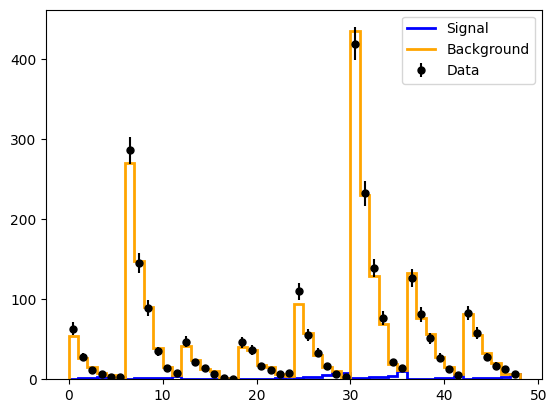

/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_67753/1668377708.py:8: RuntimeWarning: invalid value encountered in log
  return 2*np.sum(mu - N + N*np.log(N/mu))


Mass: 100 MeV
Observed limit: 0.32
Expected limit: 0.29


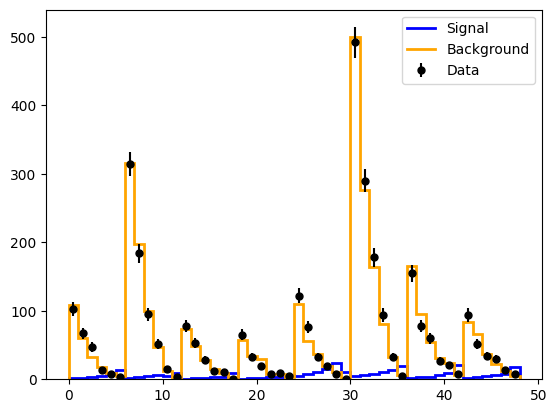

Mass: 150 MeV
Observed limit: 0.10
Expected limit: 0.13


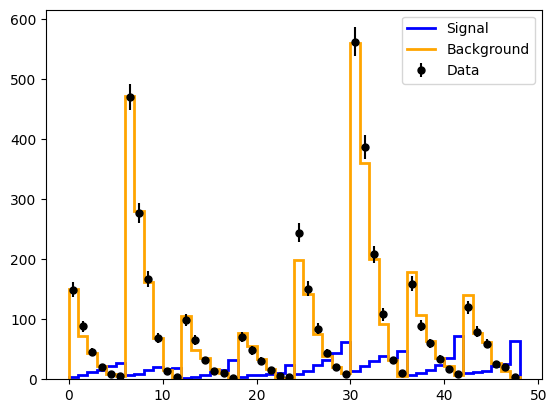

Mass: 200 MeV
Observed limit: 0.07
Expected limit: 0.04


In [58]:
test_mass = 100
dict_to_use = Total_dict_both

cl_lims = []
mass_points = [100, 150, 200]
cls_thresh  = 0.95 # 0.9, 0.95, 0.99

mu = np.logspace(-2, 0, 50)
n_uni = 10000


for mass in mass_points:
    s = dict_to_use[mass]['TOT_SIGNAL_VALS']
    s_err = dict_to_use[mass]['TOT_SIGNAL_ERR']
    b = dict_to_use[mass]['TOT_BKG_VALS']
    b_err = dict_to_use[mass]['TOT_BKG_ERR']
    data = dict_to_use[mass]['data']


    s = hist_prep(np.array(s))
    s_err = hist_prep(np.array(s_err))
    b = hist_prep(np.array(b))
    b_err = hist_prep(np.array(b_err))
    data = hist_prep(np.array(data))

    bins = np.linspace(0, len(s), len(s)+1)  # Assuming bins are just indices for the histograms
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.stairs(s, bins, label='Signal', color='blue', linewidth=2)
    plt.stairs(b, bins, label='Background', color='orange', linewidth=2)
    plt.errorbar(bin_centers, data, yerr=np.sqrt(data), fmt='o', label='Data', color='black', markersize=5)
    plt.legend()
    plt.show()
    limits = []

    for sf in mu:
        lims = get_obs_exp_cls(data, s*sf, s_err*sf, b, b_err, n_uni=n_uni)
        limits.append(lims)


    # cls_obs, cls_exp, cls_exp_1up, cls_exp_1down, cls_exp_2up, cls_exp_2down
    limits = np.array(limits)
    obs_lims = limits[:, 0]
    exp_lims = limits[:, 1]
    sigma_1_up_lims = limits[:, 2]
    sigma_1_down_lims = limits[:, 3]
    sigma_2_up_lims = limits[:, 4]
    sigma_2_down_lims = limits[:, 5]

    alpha = 1 - cls_thresh

    obs_lim = get_limit(mu, obs_lims, alpha)
    exp_lim = get_limit(mu, exp_lims, alpha)
    sigma_1_up = get_limit(mu, sigma_1_up_lims, alpha)
    sigma_1_down = get_limit(mu, sigma_1_down_lims, alpha)
    sigma_2_up = get_limit(mu, sigma_2_up_lims, alpha)
    sigma_2_down = get_limit(mu, sigma_2_down_lims, alpha)
    print(f"Mass: {mass} MeV")
    print(f"Observed limit: {obs_lim:.2f}")
    print(f"Expected limit: {exp_lim:.2f}")

    cl_lims.append([obs_lim, exp_lim, sigma_1_up, sigma_1_down, sigma_2_up, sigma_2_down])
cl_lims = np.array(cl_lims)

Mass: 100 MeV
Observed limit: 0.29
Expected limit: 0.27
Mass: 150 MeV
Observed limit: 0.08
Expected limit: 0.10
Mass: 200 MeV
Observed limit: 0.07
Expected limit: 0.04

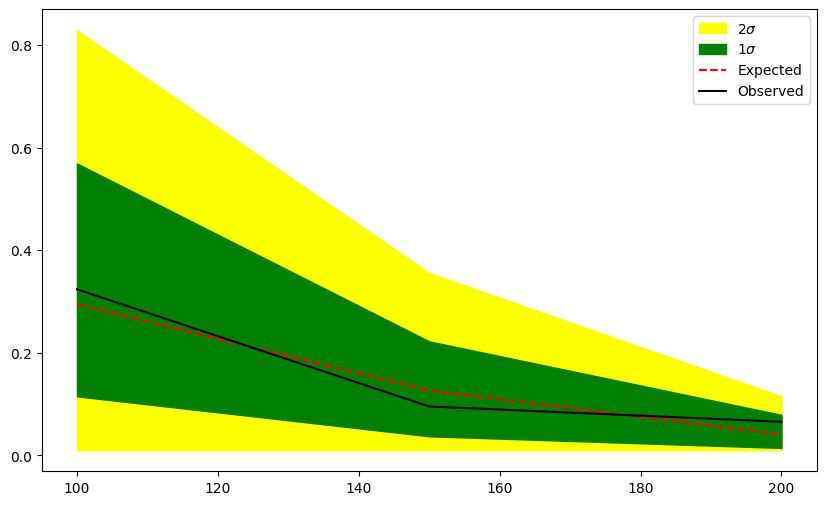

(0.0002, 0.0008)

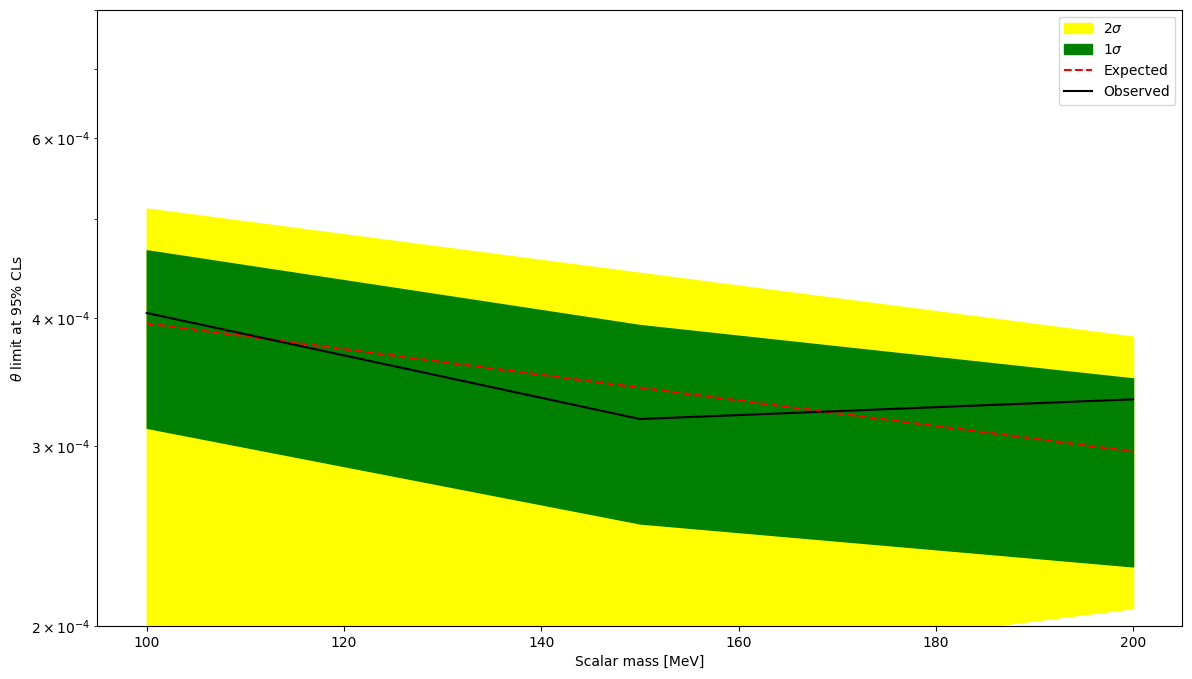

In [59]:
obs_lims = cl_lims[:, 0]
exp_lims = cl_lims[:, 1]
sigma_1_up_lims = cl_lims[:, 2]
sigma_1_down_lims = cl_lims[:, 3]
sigma_2_up_lims = cl_lims[:, 4]
sigma_2_down_lims = cl_lims[:, 5]

plt.figure(figsize=(10, 6))
plt.fill_between(mass_points, sigma_2_down_lims, sigma_2_up_lims, color='yellow', alpha=1, label='2$\sigma$')

plt.fill_between(mass_points, sigma_1_down_lims, sigma_1_up_lims, color='green', alpha=1, label='1$\sigma$')

plt.plot(mass_points, exp_lims, label='Expected', color='red', linestyle='--')
plt.plot(mass_points, obs_lims, label='Observed', color='k')
plt.legend()
plt.show()


# getting limits on theta...

obs_theta = []
exp_theta = []

for i, mass in enumerate(mass_points):
    theta = theta_dict[mass]

    obs = theta * pow(obs_lims[i], 0.25)
    exp = theta * pow(exp_lims[i], 0.25)
    sigma_1_up = theta * pow(sigma_1_up_lims[i], 0.25)
    sigma_1_down = theta * pow(sigma_1_down_lims[i], 0.25)
    sigma_2_up = theta * pow(sigma_2_up_lims[i], 0.25)
    sigma_2_down = theta * pow(sigma_2_down_lims[i], 0.25)
    
    obs_theta.append(obs)
    exp_theta.append([exp, sigma_1_up, sigma_1_down, sigma_2_up, sigma_2_down])

exp_theta = np.array(exp_theta)

plt.figure(figsize=(14,8),facecolor='white',dpi=100)
plt.fill_between(mass_points, exp_theta[:, 3], exp_theta[:, 4], color='yellow', alpha=1, label='2$\sigma$')
plt.fill_between(mass_points, exp_theta[:, 1], exp_theta[:, 2], color='green', alpha=1, label='1$\sigma$')
plt.plot(mass_points, exp_theta[:, 0], label='Expected', color='red', linestyle='--')
plt.plot(mass_points, obs_theta, label='Observed', color='k')
plt.yscale('log')
plt.legend()
plt.xlabel(r'Scalar mass [MeV]')
plt.ylabel(r'$\theta$ limit at 95% CLs')

plt.ylim(2e-4, 8e-4)


# Re-writing hist loading

In [86]:
def load_hists(location = root_dir + 'BDT_output/', masses = [100, 150, 200]):

    hist_dict, theta_dict = {}, {},

    all_hists_list = ['bkg_overlay;1', 'bkg_dirt;1', 'bkg_EXT;1', 'signal;1', 'data;1', 'theta;1',  
                      'ppfx_uncertainty_frac;1', 'Genie_uncertainty_frac;1', 'Reinteraction_uncertainty_frac;1', 
                      'overlay_DetVar_uncertainty_frac;1', 'signal_DetVar_uncertainty_frac;1', "signal_KDAR_frac;1"]
    missing_hists = []
    for mass in masses:
        for run in ['run1', 'run3']:
            for shr in ['1shr', '2shr']:
                for kdar in ['KDIF', 'KDAR']:

                    name = location + f'{run}_ALL_Capped_{mass}_{shr}_{kdar}.root'
                    hist_dict[f"{run}_{mass}_{shr}_{kdar}"] = uproot.open(name)

                    for hist in all_hists_list:
                        if hist not in hist_dict[f"{run}_{mass}_{shr}_{kdar}"].keys():
                            missing_hists.append(f"{run}_{mass}_{shr}_{kdar} {hist}")
                            print(f"Missing hist: {run}_{mass}_{shr}_{kdar} {hist}")
                            continue
        theta_dict[mass] = hist_dict[f"{run}_{mass}_{shr}_{kdar}"]['theta'].values()[0]

    print('Missings hists:\n', missing_hists)
    return hist_dict, theta_dict

def convert_hists_to_df(uproot_hists, bin_cut = None):

    hist_df = pd.DataFrame()

    hist_df['logit_score'] = uproot_hists['signal'].axis().centers()

    # Signal w/ systematics
    hist_df['SIG'] = uproot_hists['signal'].values()

    signal_syst_frac2 = uproot_hists['signal_DetVar_uncertainty_frac'].values() **2 + uproot_hists['signal_KDAR_frac'].values() **2
    signal_syst2 = signal_syst_frac2 * hist_df['SIG'] **2 + uproot_hists['signal'].errors() **2
    hist_df['SIG_TOT_UNCERT'] = np.sqrt(signal_syst2)
    hist_df['SIG_STAT'] = uproot_hists['signal'].errors()
    hist_df['SIG_SYST'] = np.sqrt(signal_syst_frac2) * hist_df['SIG']
    # Bkg w/ systematics 
    hist_df['bkg_overlay'] = uproot_hists['bkg_overlay'].values()
    overlay_syst_frac2 = uproot_hists['ppfx_uncertainty_frac'].values() **2 + uproot_hists['Genie_uncertainty_frac'].values() **2 
    + uproot_hists['Reinteraction_uncertainty_frac'].values() **2 + uproot_hists['overlay_DetVar_uncertainty_frac'].values() **2
    overlay_syst2 = overlay_syst_frac2 * hist_df['bkg_overlay'] **2 + uproot_hists['bkg_overlay'].errors() **2
    hist_df['bkg_overlay_tot_uncert'] = np.sqrt(overlay_syst2)
    hist_df['bkg_overlay_stat'] = uproot_hists['bkg_overlay'].errors()
    # hist_df['bkg_overlay_syst'] = np.sqrt(overlay_syst_frac2) * hist_df['bkg_overlay']
    hist_df['bkg_overlay_multisim'] = np.sqrt(uproot_hists['ppfx_uncertainty_frac'].values() **2 + uproot_hists['Genie_uncertainty_frac'].values() **2 
    + uproot_hists['Reinteraction_uncertainty_frac'].values() **2) * hist_df['bkg_overlay']
    hist_df['bkg_overlay_detvar'] = uproot_hists['overlay_DetVar_uncertainty_frac'].values() * hist_df['bkg_overlay']
    hist_df['bkg_dirt'] = uproot_hists['bkg_dirt'].values()
    hist_df['bkg_dirt_tot_uncert'] = uproot_hists['bkg_dirt'].errors()
    hist_df['bkg_EXT'] = uproot_hists['bkg_EXT'].values()
    hist_df['bkg_EXT_tot_uncert'] = uproot_hists['bkg_EXT'].errors()
    hist_df['data'] = uproot_hists['data'].values()
    hist_df['data_stat'] = uproot_hists['data'].errors()

    bkg = hist_df['bkg_overlay'] + hist_df['bkg_dirt'] + hist_df['bkg_EXT']
    bkg_tot_uncert = np.sqrt(hist_df['bkg_overlay_tot_uncert'] **2 + hist_df['bkg_dirt_tot_uncert'] **2 + hist_df['bkg_EXT_tot_uncert'] **2)
    hist_df['BKG'] = bkg
    hist_df['BKG_TOT_UNCERT'] = bkg_tot_uncert
    return hist_df[bin_cut:]

# Choose which runs and channels to merge
# For example, to merge run1 and run3 for 1shr and KDIF:
# merging_dict = {'runs': ['run1','run3'],
#     'shr': ['1shr'],
#     'k': ['KDIF'],}

def merge_hists(df_dict, mass, merging_dict):
    """
    Merges the histograms in the df_dict according to the merging_dict.
    """
    runs = merging_dict['runs']
    shrs = merging_dict['shr']
    k = merging_dict['k']

    merged_df = None
    for run in runs:
        for shr in shrs:
            for kdar in k:
                name = f"{run}_{mass}_{shr}_{kdar}"
                if merged_df is None:
                    merged_df = df_dict[mass][name]
                else:
                    merged_df = pd.concat([merged_df, df_dict[mass][name]], axis=0)
    merged_df = merged_df.reset_index(drop=True)

    return merged_df

In [87]:
masses = [100, 150, 200]

hist_dict, theta_dict = load_hists(masses=masses)
df_dict = {}
bin_cut = -6

for mass in masses:
    df_dict[mass] = {}
    df_dict[mass]['theta'] = theta_dict[mass]
    for run in ['run1', 'run3']:
        for shr in ['1shr', '2shr']:
            for kdar in ['KDIF', 'KDAR']:
                name = f"{run}_{mass}_{shr}_{kdar}"
                df_dict[mass][name] = convert_hists_to_df(hist_dict[name], bin_cut=bin_cut)

for hist in df_dict[mass][name]:
    print(hist+ " " + str(len(df_dict[mass][name][hist])))

Missings hists:
 []
logit_score 6
SIG 6
SIG_TOT_UNCERT 6
SIG_STAT 6
SIG_SYST 6
bkg_overlay 6
bkg_overlay_tot_uncert 6
bkg_overlay_stat 6
bkg_overlay_multisim 6
bkg_overlay_detvar 6
bkg_dirt 6
bkg_dirt_tot_uncert 6
bkg_EXT 6
bkg_EXT_tot_uncert 6
data 6
data_stat 6
BKG 6
BKG_TOT_UNCERT 6


48
47 48 36


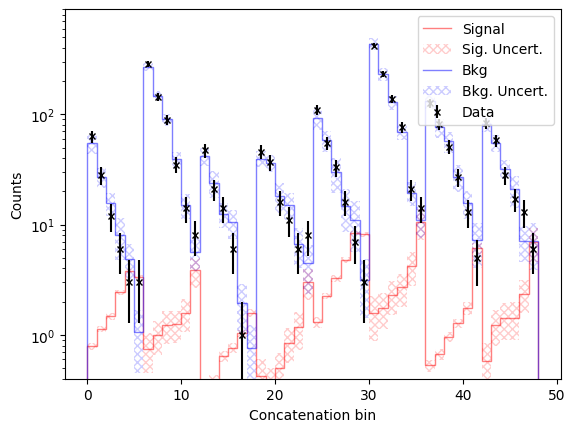

48
48 48 40


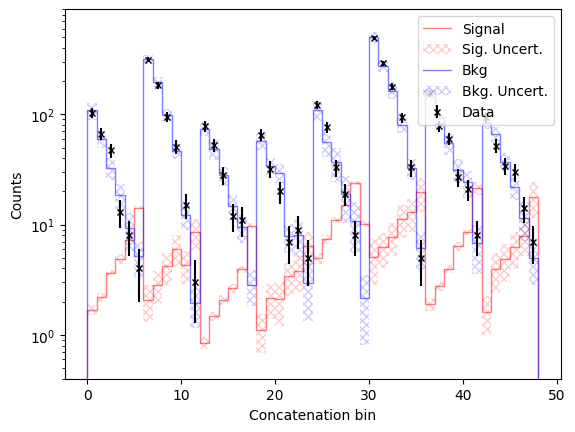

48
48 48 44


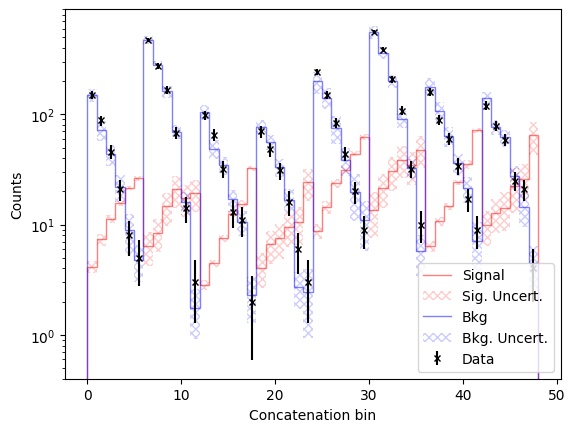

In [88]:
merging_dict = {
    'runs': ['run1', 'run3'],
    'shr': ['1shr', '2shr'],
    'k': ['KDIF', 'KDAR'],
}

mass_dict = {}

show_hist = True

for mass in masses:
    mass_dict[mass] = merge_hists(df_dict, mass, merging_dict)

    sig_hist = hist_prep(np.array(mass_dict[mass]['SIG']))
    sig_hist_uncert = hist_prep(np.array(mass_dict[mass]['SIG_TOT_UNCERT']))
    bkg_hist = hist_prep(np.array(mass_dict[mass]['BKG']))
    bkg_hist_uncert = hist_prep(np.array(mass_dict[mass]['BKG_TOT_UNCERT']))
    data_hist = hist_prep(np.array(mass_dict[mass]['data']))
    data_hist_uncert = hist_prep(np.array(mass_dict[mass]['data_stat']))

    bin_edges = np.arange(0, len(sig_hist) + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    if show_hist:
        # Checking if histograms are being merged correctly or duplicated
        print(len(sig_hist))
        print(len(np.unique(sig_hist)), len(np.unique(bkg_hist)), len(np.unique(data_hist)))
        
        plt.stairs(sig_hist, bin_edges, label='Signal', color='red', alpha=0.5)
        plt.fill_between(bin_edges, np.append(sig_hist-sig_hist_uncert, sig_hist[-1]-sig_hist_uncert[-1]), np.append(sig_hist+sig_hist_uncert, sig_hist[-1]+sig_hist_uncert[-1]), label='Sig. Uncert.', step='post', facecolor="none", hatch="XXXX", edgecolor="r", linewidth=0.0, alpha=0.2)
        plt.stairs(bkg_hist, bin_edges, label='Bkg', color='blue', alpha=0.5)
        plt.fill_between(bin_edges, np.append(bkg_hist-bkg_hist_uncert, bkg_hist[-1]-bkg_hist_uncert[-1]), np.append(bkg_hist+bkg_hist_uncert, bkg_hist[-1]+bkg_hist_uncert[-1]), label='Bkg. Uncert.', step='post', facecolor="none", hatch="XXXX", edgecolor="b", linewidth=0.0, alpha=0.2)
        
        plt.errorbar(bin_centers, data_hist, yerr=data_hist_uncert, fmt='x', label='Data', color='black', markersize=5)
        plt.legend()
        plt.xlabel('Concatenation bin')
        plt.ylabel('Counts')
        plt.yscale('log')
        plt.ylim(4e-1, 9e2)
        plt.show()

## Manual CLs implementation...

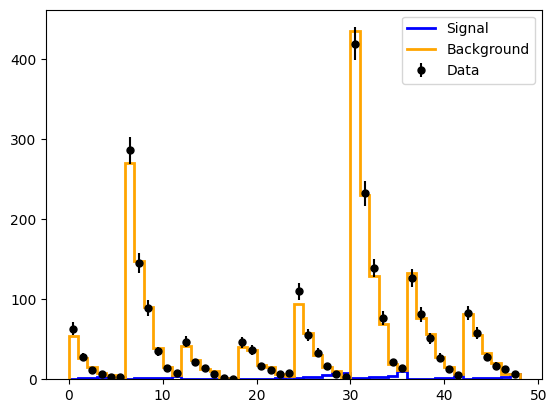

/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_67753/1668377708.py:8: RuntimeWarning: invalid value encountered in log
  return 2*np.sum(mu - N + N*np.log(N/mu))


Mass: 100 MeV
Observed limit: 0.29
Expected limit: 0.24


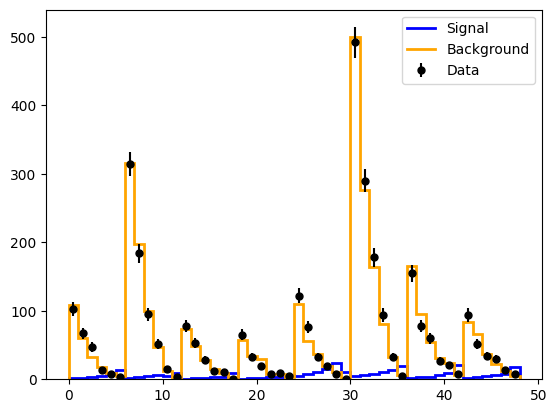

Mass: 150 MeV
Observed limit: 0.08
Expected limit: 0.10


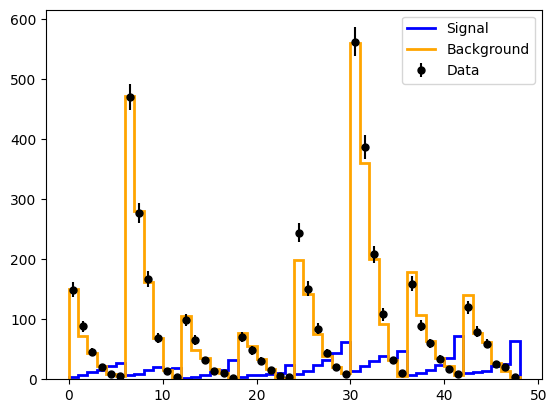

Mass: 200 MeV
Observed limit: 0.07
Expected limit: 0.04


In [63]:
k = ['KDIF', 'KDAR']
nshrs = ['1shr', '2shr']
runs = ['run1', 'run3']

# Limit-setting parameters
mu = np.logspace(-2, 0, 50)
n_uni = 10000

cl_lims = []

for mass in masses:
    mass_dict[mass] = merge_hists(df_dict, mass, merging_dict)
    sig_hist = hist_prep(np.array(mass_dict[mass]['SIG']))
    sig_hist_uncert = hist_prep(np.array(mass_dict[mass]['SIG_TOT_UNCERT']))
    bkg_hist = hist_prep(np.array(mass_dict[mass]['BKG']))
    bkg_hist_uncert = hist_prep(np.array(mass_dict[mass]['BKG_TOT_UNCERT']))
    data_hist = hist_prep(np.array(mass_dict[mass]['data']))
    data_hist_uncert = hist_prep(np.array(mass_dict[mass]['data_stat']))

    bins = np.linspace(0, len(sig_hist), len(sig_hist)+1)  # Assuming bins are just indices for the histograms
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.stairs(sig_hist, bins, label='Signal', color='blue', linewidth=2)
    plt.stairs(bkg_hist, bins, label='Background', color='orange', linewidth=2)
    plt.errorbar(bin_centers, data_hist, yerr=np.sqrt(data_hist), fmt='o', label='Data', color='black', markersize=5)
    plt.legend()
    plt.show()

    limits = []
    for sf in mu:
        lims = get_obs_exp_cls(data_hist, sig_hist*sf, sig_hist_uncert*sf, bkg_hist, bkg_hist_uncert, n_uni=n_uni, plot_test_hist=False)
        limits.append(lims)

    limits = np.array(limits)
    obs_lims = limits[:, 0]
    exp_lims = limits[:, 1]
    sigma_1_up_lims = limits[:, 2]
    sigma_1_down_lims = limits[:, 3]
    sigma_2_up_lims = limits[:, 4]
    sigma_2_down_lims = limits[:, 5]

    alpha = 1 - cls_thresh

    obs_lim = get_limit(mu, obs_lims, alpha)
    exp_lim = get_limit(mu, exp_lims, alpha)
    sigma_1_up = get_limit(mu, sigma_1_up_lims, alpha)
    sigma_1_down = get_limit(mu, sigma_1_down_lims, alpha)
    sigma_2_up = get_limit(mu, sigma_2_up_lims, alpha)
    sigma_2_down = get_limit(mu, sigma_2_down_lims, alpha)
    print(f"Mass: {mass} MeV")
    print(f"Observed limit: {obs_lim:.2f}")
    print(f"Expected limit: {exp_lim:.2f}")

    cl_lims.append([obs_lim, exp_lim, sigma_1_up, sigma_1_down, sigma_2_up, sigma_2_down])
cl_lims = np.array(cl_lims)

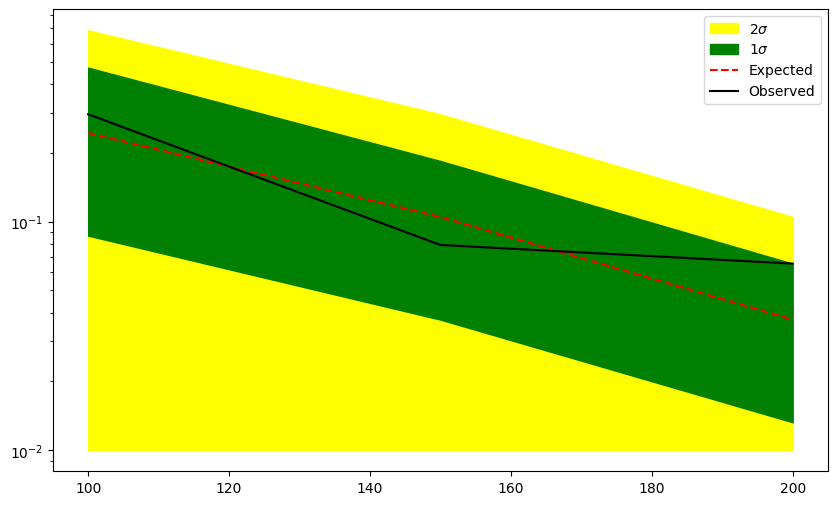

In [64]:
obs_lims = cl_lims[:, 0]
exp_lims = cl_lims[:, 1]
sigma_1_up_lims = cl_lims[:, 2]
sigma_1_down_lims = cl_lims[:, 3]
sigma_2_up_lims = cl_lims[:, 4]
sigma_2_down_lims = cl_lims[:, 5]

plt.figure(figsize=(10, 6))
plt.fill_between(masses, sigma_2_down_lims, sigma_2_up_lims, color='yellow', alpha=1, label='2$\sigma$')

plt.fill_between(masses, sigma_1_down_lims, sigma_1_up_lims, color='green', alpha=1, label='1$\sigma$')

plt.plot(masses, exp_lims, label='Expected', color='red', linestyle='--')
plt.plot(masses, obs_lims, label='Observed', color='k')
plt.legend()
plt.yscale('log')
plt.show()

(0.0002, 0.0008)

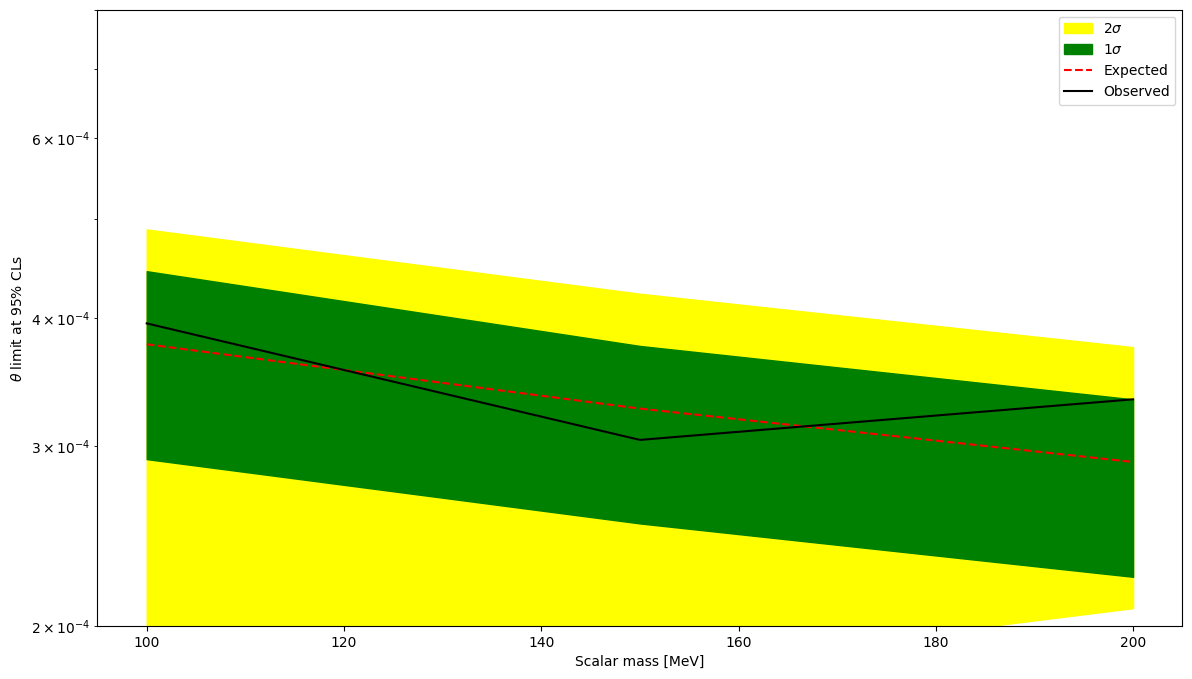

In [65]:
# getting limits on theta...

obs_theta = []
exp_theta = []

for i, mass in enumerate(masses):
    theta = df_dict[mass]['theta']

    obs = theta * pow(obs_lims[i], 0.25)
    exp = theta * pow(exp_lims[i], 0.25)
    sigma_1_up = theta * pow(sigma_1_up_lims[i], 0.25)
    sigma_1_down = theta * pow(sigma_1_down_lims[i], 0.25)
    sigma_2_up = theta * pow(sigma_2_up_lims[i], 0.25)
    sigma_2_down = theta * pow(sigma_2_down_lims[i], 0.25)

    obs_theta.append(obs)
    exp_theta.append([exp, sigma_1_up, sigma_1_down, sigma_2_up, sigma_2_down])

exp_theta = np.array(exp_theta)

plt.figure(figsize=(14,8),facecolor='white',dpi=100)
plt.fill_between(masses, exp_theta[:, 3], exp_theta[:, 4], color='yellow', alpha=1, label='2$\sigma$')
plt.fill_between(masses, exp_theta[:, 1], exp_theta[:, 2], color='green', alpha=1, label='1$\sigma$')
plt.plot(masses, exp_theta[:, 0], label='Expected', color='red', linestyle='--')
plt.plot(masses, obs_theta, label='Observed', color='k')
plt.yscale('log')
plt.legend()
plt.xlabel(r'Scalar mass [MeV]')
plt.ylabel(r'$\theta$ limit at 95% CLs')

plt.ylim(2e-4, 8e-4)

## Going back to pyhf...

In [89]:
Params_pyhf = {
"Signal_flux_error":0.3, # Dont think we should be using this, as its included in the signal syst for KDAR only...
"Overlay_detvar_frac":0.3,
"Flat_bkg_overlay_frac":0.3,
"Flat_bkg_dirt_frac":0.75,
"Flat_bkg_EXT_frac":0.0,
"Flat_sig_detvar":0.2, 
}


def create_pyhf_model_separated(dataframe, params=Params_pyhf):
    sig_norm = {'hi': 1+ params['Signal_flux_error'], 'lo': 1 - params['Signal_flux_error']}
    dirt_norm = {'hi': 1+ params['Flat_bkg_dirt_frac'], 'lo': 1 - params['Flat_bkg_dirt_frac']}
    model = pyhf.Model(
        {
            "channels":
            [
                {
                    "name": "singlechannel",
                    "samples": 
                    [
                        {
                            "name": "signal",
                            "data": dataframe['SIG'].values,
                            "modifiers": [
                                
                                {
                                    "name": "mu", "type": "normfactor", "data": None, 
                                }, # signal strength
                                {
                                    "name": "sig_stat", "type": "staterror", "data": dataframe['SIG_STAT'].values
                                },
                                {
                                    "name": "sig_syst", "type": "shapesys", "data": dataframe['SIG_SYST'].values
                                },
                            
                            ]
                        },
                        {
                            "name": "bkg_overlay",
                            "data": dataframe['bkg_overlay'].values,
                            "modifiers": [
                                {
                                    "name": "overlay_stat", "type": "staterror", "data": dataframe['bkg_overlay_stat'].values
                                },
                                {
                                    "name": "overlay_multsim", "type": "shapesys", "data": dataframe['bkg_overlay_multisim'].values
                                },
                                {
                                    "name": "overlay_detvar", "type": "shapesys", "data": dataframe['bkg_overlay_detvar'].values
                                }

                            ]
                        },
                        {
                            "name": "bkg_dirt",
                            "data": dataframe['bkg_dirt'].values,
                            "modifiers": [
                                {
                                    "name": "dirt_stat", "type": "staterror", "data": dataframe['bkg_dirt_tot_uncert'].values
                                },
                                {
                                    "name": "dirt_norm", "type": "normsys", "data": dirt_norm
                                }
                            ]
                        },
                        {
                            "name": 'bkg_EXT',
                            'data': dataframe['bkg_EXT'].values,
                            'modifiers': [
                                {
                                    'name': 'ext_stat', 'type': 'staterror', 'data': dataframe['bkg_EXT_tot_uncert'].values
                                }
                            ]
                        }
                    ]
                }
            ],
        }
    )
    return model

def create_pyhf_model_same(dataframe, params=Params_pyhf):
    model = pyhf.Model(
        {
              "channels": 
        [
            {
            "name": "singlechannel",
            "samples": 
                [
                    {
                        "name": "signal",
                        "data": dataframe['SIG'].values,
                        "modifiers": [
                            {
                                "name": "mu", "type": "normfactor", "data": None, 
                            }, # signal strength
                            {
                                "name": "uncorr_siguncrt", "type": "shapesys", "data": dataframe['SIG_TOT_UNCERT'].values
                            },
                        ]
                    },
                    {
                        "name": "background",
                        "data": dataframe['BKG'].values,
                        "modifiers": [
                            {
                                "name": "uncorr_bkguncrt", "type": "shapesys", "data": dataframe['BKG_TOT_UNCERT'].values
                            },
                        ]
                    }
                ]
            }
        ],
              "parameters": [
            {
                "name": "mu",
                "bounds": [[0, 1000000]],
            }
      ],
    }
    )
    return model

In [ ]:
poi_values = np.logspace(-2, 0, 25)

CLs_thresh = 0.95
alpha = 1 - CLs_thresh

obs_limit_dict = {}
exp_limit_dict = {}

for mass in masses:
    dataframe = mass_dict[mass]
    model = create_pyhf_model_same(dataframe) # create_pyhf_model_separated(dataframe)

    init_pars = model.config.suggested_init()
    model.expected_actualdata(init_pars) #signal plus bkg
    bkg_pars = init_pars.copy()
    bkg_pars[model.config.poi_index] = 0
    model.expected_actualdata(bkg_pars) #bkg only
    
    data = list(dataframe['data']) + model.config.auxdata


    print("Max value is " + str(max(poi_values)))
    print("Min value is " + str(min(poi_values)))
    print("Next value is " + str(poi_values[1]))
    print("Next value is " + str(poi_values[2]) + "\n")

    

    obs, exp, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
        data, model, poi_values, level=alpha, return_results=True
    )
    print(f"Upper limit {mass}MeV (obs): μ = {obs:.6f}")
    print(f"Upper limit {mass}MeV (exp): μ = {exp[2]:.6f}" + "\n")
    obs_limit_dict[mass] = obs
    exp_limit_dict[mass] = exp



Max value is 1.0
Min value is 0.01
Next value is 0.012115276586285882
Next value is 0.014677992676220698



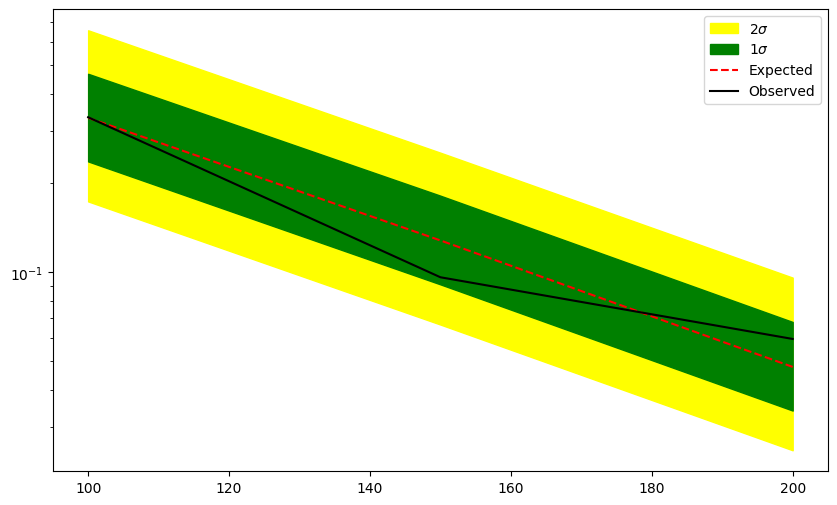

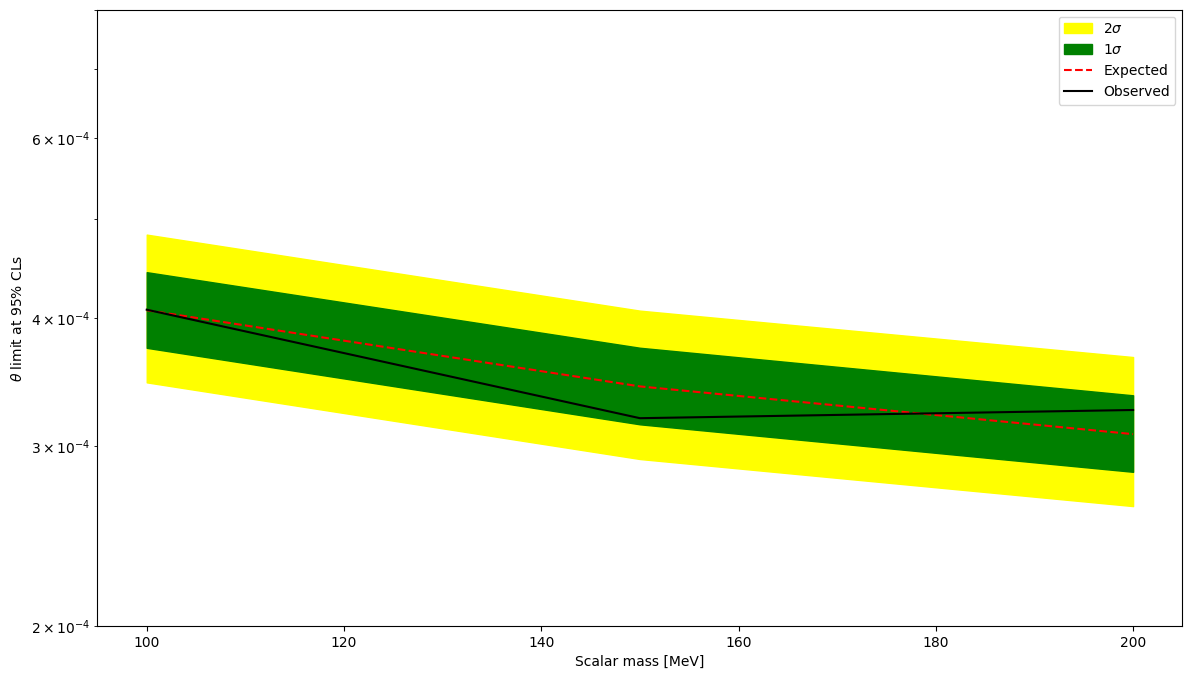

In [ ]:
obs_lims = []
exp_lims = []
sigma_1_up_lims = []
sigma_1_down_lims = []
sigma_2_up_lims = []
sigma_2_down_lims = []

for mass in masses:
    obs_lims.append(obs_limit_dict[mass])
    exp_lims.append(exp_limit_dict[mass][2])
    sigma_1_up_lims.append(exp_limit_dict[mass][3])
    sigma_1_down_lims.append(exp_limit_dict[mass][1])
    sigma_2_up_lims.append(exp_limit_dict[mass][4])
    sigma_2_down_lims.append(exp_limit_dict[mass][0])

plt.figure(figsize=(10, 6))
plt.fill_between(masses, sigma_2_down_lims, sigma_2_up_lims, color='yellow', alpha=1, label='2$\sigma$')

plt.fill_between(masses, sigma_1_down_lims, sigma_1_up_lims, color='green', alpha=1, label='1$\sigma$')

plt.plot(masses, exp_lims, label='Expected', color='red', linestyle='--')
plt.plot(masses, obs_lims, label='Observed', color='k')
plt.legend()
plt.yscale('log')
plt.show()

# getting limits on theta...
obs_theta = []
exp_theta = []

for i, mass in enumerate(masses):
    theta = df_dict[mass]['theta']

    obs = theta * pow(obs_lims[i], 0.25)
    exp = theta * pow(exp_lims[i], 0.25)
    sigma_1_up = theta * pow(sigma_1_up_lims[i], 0.25)
    sigma_1_down = theta * pow(sigma_1_down_lims[i], 0.25)
    sigma_2_up = theta * pow(sigma_2_up_lims[i], 0.25)
    sigma_2_down = theta * pow(sigma_2_down_lims[i], 0.25)

    obs_theta.append(obs)
    exp_theta.append([exp, sigma_1_up, sigma_1_down, sigma_2_up, sigma_2_down])

exp_theta = np.array(exp_theta)

plt.figure(figsize=(14,8),facecolor='white',dpi=100)
plt.fill_between(masses, exp_theta[:, 3], exp_theta[:, 4], color='yellow', alpha=1, label='2$\sigma$')
plt.fill_between(masses, exp_theta[:, 1], exp_theta[:, 2], color='green', alpha=1, label='1$\sigma$')
plt.plot(masses, exp_theta[:, 0], label='Expected', color='red', linestyle='--')
plt.plot(masses, obs_theta, label='Observed', color='k')
plt.yscale('log')
plt.legend()
plt.xlabel(r'Scalar mass [MeV]')
plt.ylabel(r'$\theta$ limit at 95% CLs')
plt.ylim(2e-4, 8e-4)
plt.show()


# Varying BDT Score Cuts

In [61]:
def convert_hists_to_df_scorecut(uproot_hists, score_cut = None):

    hist_df = pd.DataFrame()

    hist_df['logit_score'] = uproot_hists['signal'].axis().centers()
    # bin_cut = np.where(hist_df['logit_score'] > score_cut)[0][0]
    bin_cut = hist_df['logit_score'] > score_cut

    # Signal w/ systematics
    hist_df['SIG'] = uproot_hists['signal'].values()

    signal_syst_frac2 = uproot_hists['signal_DetVar_uncertainty_frac'].values() **2 + uproot_hists['signal_KDAR_frac'].values() **2
    signal_syst2 = signal_syst_frac2 * hist_df['SIG'] **2 + uproot_hists['signal'].errors() **2
    hist_df['SIG_TOT_UNCERT'] = np.sqrt(signal_syst2)
    hist_df['SIG_STAT'] = uproot_hists['signal'].errors()
    hist_df['SIG_SYST'] = np.sqrt(signal_syst_frac2) * hist_df['SIG']
    # Bkg w/ systematics 
    hist_df['bkg_overlay'] = uproot_hists['bkg_overlay'].values()
    overlay_syst_frac2 = uproot_hists['ppfx_uncertainty_frac'].values() **2 + uproot_hists['Genie_uncertainty_frac'].values() **2 
    + uproot_hists['Reinteraction_uncertainty_frac'].values() **2 + uproot_hists['overlay_DetVar_uncertainty_frac'].values() **2
    overlay_syst2 = overlay_syst_frac2 * hist_df['bkg_overlay'] **2 + uproot_hists['bkg_overlay'].errors() **2
    hist_df['bkg_overlay_tot_uncert'] = np.sqrt(overlay_syst2)
    hist_df['bkg_overlay_stat'] = uproot_hists['bkg_overlay'].errors()
    # hist_df['bkg_overlay_syst'] = np.sqrt(overlay_syst_frac2) * hist_df['bkg_overlay']
    hist_df['bkg_overlay_multisim'] = np.sqrt(uproot_hists['ppfx_uncertainty_frac'].values() **2 + uproot_hists['Genie_uncertainty_frac'].values() **2 
    + uproot_hists['Reinteraction_uncertainty_frac'].values() **2) * hist_df['bkg_overlay']
    hist_df['bkg_overlay_detvar'] = uproot_hists['overlay_DetVar_uncertainty_frac'].values() * hist_df['bkg_overlay']
    hist_df['bkg_dirt'] = uproot_hists['bkg_dirt'].values()
    hist_df['bkg_dirt_tot_uncert'] = uproot_hists['bkg_dirt'].errors()
    hist_df['bkg_EXT'] = uproot_hists['bkg_EXT'].values()
    hist_df['bkg_EXT_tot_uncert'] = uproot_hists['bkg_EXT'].errors()
    hist_df['data'] = uproot_hists['data'].values()
    hist_df['data_stat'] = uproot_hists['data'].errors()

    bkg = hist_df['bkg_overlay'] + hist_df['bkg_dirt'] + hist_df['bkg_EXT']
    bkg_tot_uncert = np.sqrt(hist_df['bkg_overlay_tot_uncert'] **2 + hist_df['bkg_dirt_tot_uncert'] **2 + hist_df['bkg_EXT_tot_uncert'] **2)
    hist_df['BKG'] = bkg
    hist_df['BKG_TOT_UNCERT'] = bkg_tot_uncert
    # return hist_df[bin_cut:]
    return hist_df[bin_cut]

In [102]:
mass_point = 150

hist_dict, theta_dict = load_hists(masses=[mass_point])
df_dict = {}

cut_arr = np.arange(-7, 5)

df_dict = {}


for cut in cut_arr:
    df_dict[cut] = {}
    df_dict[cut]['theta'] = theta_dict[mass_point]
    for run in ['run1', 'run3']:
        for shr in ['1shr', '2shr']:
            for kdar in ['KDIF', 'KDAR']:
                name = f"{run}_{mass_point}_{shr}_{kdar}"
                df_dict[cut][name] = convert_hists_to_df_scorecut(hist_dict[name], score_cut=cut)



Missings hists:
 []


In [ ]:
test_hist = 'run3_150_1shr_KDIF'

poi_values = np.logspace(-2, 0, 50)

CLs_thresh = 0.95
alpha = 1 - CLs_thresh

exp_lim_dict = {}
for cut in cut_arr:
    for mass_point in [100, 150, 200]:
        for run in ['run1', 'run3']: 
            for shr in ['1shr', '2shr']:
                for kdar in ['KDIF', 'KDAR']:
                    hist_name = f"{run}_{mass_point}_{shr}_{kdar}"
                    print(f"Logit cut: {cut}")
                    dataframe = df_dict[cut][hist_name]
                    model = create_pyhf_model_same(dataframe)
                    init_pars = model.config.suggested_init()
                    model.expected_actualdata(init_pars) #signal plus bkg
                    bkg_pars = init_pars.copy()
                    bkg_pars[model.config.poi_index] = 0
                    model.expected_actualdata(bkg_pars) #bkg only
                    
                    data = list(dataframe['data']) + model.config.auxdata

                    obs, exp, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
                        data, model, poi_values, level=alpha, return_results=True
                    )
                    print(f"Upper limit {mass_point}MeV (obs): μ = {obs:.6f}")
                    print(f"Upper limit {mass_point}MeV (exp): μ = {exp[2]:.6f}" + "\n")
                    # exp_lim_arr.append(exp[2])
                    exp_theta = theta * pow(exp[2], 0.25)



                    if hist_name not in exp_lim_dict:
                        exp_lim_dict[hist_name] = []
                    exp_lim_dict[hist_name].append(exp_theta)

                # print(f"Upper limit {mass_point}MeV (exp): θ = {exp_theta:.8f}" + "\n")



Logit cut: -7
Upper limit 150MeV (obs): μ = 0.333304
Upper limit 150MeV (exp): μ = 0.402245

Logit cut: -7
Upper limit 150MeV (obs): μ = 0.766832
Upper limit 150MeV (exp): μ = 0.568077

Logit cut: -7
Upper limit 150MeV (obs): μ = 0.257081
Upper limit 150MeV (exp): μ = 0.439024

Logit cut: -7
Upper limit 150MeV (obs): μ = 0.994073
Upper limit 150MeV (exp): μ = 0.858443

Logit cut: -7
Upper limit 150MeV (obs): μ = 0.173188
Upper limit 150MeV (exp): μ = 0.259971

Logit cut: -7
Upper limit 150MeV (obs): μ = 0.377392
Upper limit 150MeV (exp): μ = 0.396600

Logit cut: -7
Upper limit 150MeV (obs): μ = 0.404716
Upper limit 150MeV (exp): μ = 0.389337

Logit cut: -7
Upper limit 150MeV (obs): μ = 0.608344
Upper limit 150MeV (exp): μ = 0.448484

Logit cut: -6
Upper limit 150MeV (obs): μ = 0.333305
Upper limit 150MeV (exp): μ = 0.402247

Logit cut: -6
Upper limit 150MeV (obs): μ = 0.767047
Upper limit 150MeV (exp): μ = 0.568070

Logit cut: -6
Upper limit 150MeV (obs): μ = 0.257081
Upper limit 150Me

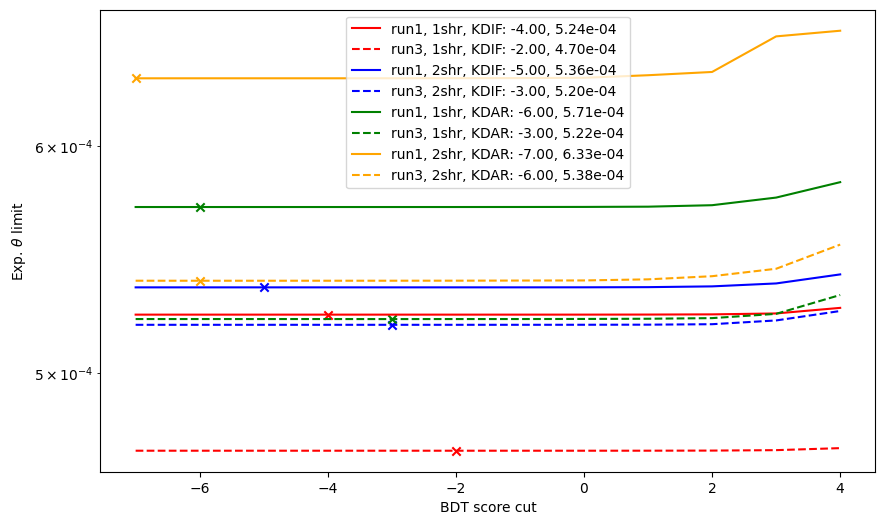

In [150]:
color_arr = ['red', 'blue', 'green', 'orange']#, 'purple', 'brown', 'pink', 'gray']
i = 0

cut_dict = {}

plt.figure(figsize=(10, 6))
for kdar in ['KDIF', 'KDAR']:
    for shr in ['1shr', '2shr']:
        color = color_arr[i]
        for run in ['run1', 'run3']: 
            ls = '--' if run == 'run3' else '-'
            
            
            hist_name = f"{run}_{mass_point}_{shr}_{kdar}"
            exp_lim_arr = exp_lim_dict[hist_name]
            min_index = np.argmin(exp_lim_arr)
            min_value = exp_lim_arr[min_index]
            min_cut = cut_arr[min_index]
            legend_name = f"{run}, {shr}, {kdar}: {min_cut:.2f}, {min_value:.2e}"
            plt.plot(cut_arr, exp_lim_dict[hist_name], ls=ls, color=color_arr[i], label=legend_name)
            plt.scatter(min_cut, min_value, marker='x', color=color_arr[i])

            cut_dict[hist_name] = [min_cut]
        i+=1

plt.xlabel('BDT score cut')
plt.ylabel(r'Exp. $\theta$ limit')
plt.legend()
plt.yscale('log')
# plt.ylim(4.5e-4, 5.5e-4)

## Limit setting with varied BDT score cuts

In [153]:
df_tot = None
for key in hist_dict:
    cut = cut_dict[key][0]
    df = convert_hists_to_df_scorecut(hist_dict[key], score_cut=cut)
    if df_tot is None:
        df_tot = df
    else:
        df_tot = pd.concat([df_tot, df], axis=0)
df_tot = df_tot.reset_index(drop=True)


In [155]:
poi_values = np.logspace(-2, 0, 50)

CLs_thresh = 0.95
alpha = 1 - CLs_thresh

dataframe = df_tot
model = create_pyhf_model_same(dataframe) # create_pyhf_model_separated(dataframe)

init_pars = model.config.suggested_init()
model.expected_actualdata(init_pars) #signal plus bkg
bkg_pars = init_pars.copy()
bkg_pars[model.config.poi_index] = 0
model.expected_actualdata(bkg_pars) #bkg only

data = list(dataframe['data']) + model.config.auxdata


print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")



obs, exp, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
    data, model, poi_values, level=alpha, return_results=True
)
print(f"Upper limit {mass}MeV (obs): μ = {obs:.6f}")
print(f"Upper limit {mass}MeV (exp): μ = {exp[2]:.6f}" + "\n")

Max value is 1.0
Min value is 0.01
Next value is 0.010985411419875584
Next value is 0.012067926406393288

Upper limit 200MeV (obs): μ = 0.095135
Upper limit 200MeV (exp): μ = 0.126291



In [156]:
theta = df_tot['theta'].values[0]
theta = df_dict[mass]['theta']

obs_theta = theta * pow(obs, 0.25)
exp_theta = theta * pow(exp[2], 0.25)
sigma_1_up = theta * pow(exp[3], 0.25)
sigma_1_down = theta * pow(exp[1], 0.25)
sigma_2_up = theta * pow(exp[4], 0.25)
sigma_2_down = theta * pow(exp[0], 0.25)

print(f"Observed limit: {obs_theta:.2f}")
print(f"Expected limit: {exp_theta:.2f} + {sigma_1_up:.2f} - {sigma_1_down:.2f}")

KeyError: 'theta'

# CLs Test Statistics Work

In [ ]:
def T_h(N, mu, poisson=True):   
    """
    N = observed events / asiimov data
    mu = expected events
    """
    # Poisson distribution
    if poisson:
        return 2*np.sum(mu - N + N*np.log(N/mu))
    # Gaussian distribution
    else:
        return np.sum( np.log(mu/N) + np.sum((N-mu)**2/mu) )

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def get_cls(obs, s, s_uncert, b, b_uncert, n_uni=10000, show_hist=False, is_exp=False):
    h0_arr = []
    h1_arr = []
    for i in range(n_uni):
        h1_asi = np.random.normal(loc=s+b, scale=np.sqrt(s_uncert**2 + b_uncert**2))
        h0_asi = np.random.normal(loc=b, scale=b_uncert)

        deltaT_h0 = T_h(h0_asi, s+b) - T_h(h0_asi, b)
        deltaT_h1 = T_h(h1_asi, s+b) - T_h(h1_asi, b)

        h0_arr.append(deltaT_h0)
        h1_arr.append(deltaT_h1)
    
    deltaT_obs = T_h(obs, s+b) - T_h(obs, b)
    h0_arr = np.array(h0_arr)
    h0_arr = h0_arr[~np.isnan(h0_arr)]

    h1_arr = np.array(h1_arr)
    h1_arr = h1_arr[~np.isnan(h1_arr)]

    lo_T = np.min([np.min(h0_arr), np.min(h1_arr)])
    hi_T = np.max([np.max(h0_arr), np.max(h1_arr)])

    hist_bins = np.linspace(lo_T, hi_T, 100)
    hist_h0, _ = np.histogram(h0_arr, bins=hist_bins, density=True)
    hist_h1, _ = np.histogram(h1_arr, bins=hist_bins, density=True)

    p1 = np.sum(hist_h1[hist_bins[:-1] > deltaT_obs]) / np.sum(hist_h1)
    p0 = np.sum(hist_h0[hist_bins[:-1] < deltaT_obs]) / np.sum(hist_h0)

    if show_hist:
        bin_centers = 0.5*(hist_bins[1:] + hist_bins[:-1])
        plt.figure(figsize=(10, 6))
        if is_exp:
            A_start = np.max(hist_h0)
            H_start = np.median(h0_arr)
            parameters, covariance = curve_fit(gauss, bin_centers, hist_h0, p0=[A_start, H_start, np.std(h0_arr)], maxfev=10000)
            plt.plot(bin_centers, gauss(bin_centers, *parameters), label='Gaussian fit', color='red')
            plt.axvline(parameters[1] + parameters[2], color='red', linestyle='--', label='Gaussian fit + sigma')
            plt.axvline(parameters[1] - parameters[2], color='red', linestyle='--', label='Gaussian fit - sigma')
            plt.axvline(parameters[1], color='blue', linestyle='--', label='Gaussian fit mean')
        plt.stairs(hist_h0, hist_bins, label='H0', color='blue', alpha=0.5)
        plt.fill_betweenx(np.append(hist_h0, hist_h0[-1]), hist_bins, deltaT_obs, where=hist_bins < deltaT_obs, step='pre', color='blue', label=p0, alpha=0.5)
        plt.stairs(hist_h1, hist_bins, label='H1', color='orange', alpha=0.5)
        plt.fill_betweenx(np.append(hist_h1, hist_h1[-1]), hist_bins, deltaT_obs, where=hist_bins > deltaT_obs, step='pre', color='orange', label=p1, alpha=0.5)
        plt.axvline(deltaT_obs, color='r', linestyle='--', label='Observed')
        plt.xlabel(r'$\Delta$ T = T$_H$$_1$ - T$_H$$_0$')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    if is_exp:

        bin_centers = 0.5*(hist_bins[1:] + hist_bins[:-1])
        A_start = np.max(hist_h0)
        H_start = np.median(h0_arr)
        parameters, covariance = curve_fit(gauss, bin_centers, hist_h1, p0=[A_start, H_start, np.std(h0_arr)], maxfev=10000)

        sigma_up = parameters[1] + parameters[2]
        sigma_down = parameters[1] - parameters[2]

        cls_exp = p1 / (1 - p0)
        print()
        print(f"p1: {p1}, p0: {p0}, cls: {cls_exp}")
        p1 = np.sum(hist_h1[hist_bins[:-1] > sigma_up]) / np.sum(hist_h1)
        p0 = np.sum(hist_h0[hist_bins[:-1] < sigma_up]) / np.sum(hist_h0)
        cls_exp_up = p1 / (1 - p0)
        print(f"p1: {p1}, p0: {p0}, cls: {cls_exp_up}")
        p1 = np.sum(hist_h1[hist_bins[:-1] > sigma_down]) / np.sum(hist_h1)
        p0 = np.sum(hist_h0[hist_bins[:-1] < sigma_down]) / np.sum(hist_h0)
        cls_exp_down = p1 / (1 - p0)
        print(f"p1: {p1}, p0: {p0}, cls: {cls_exp_down}")
        return cls_exp, cls_exp_up, cls_exp_down

    else:
        return p1 / (1-p0)

exp_cls: 0.9167003639304485, exp_cls_up: 0.9702310073827101, exp_cls_down: 0.8037203335471458


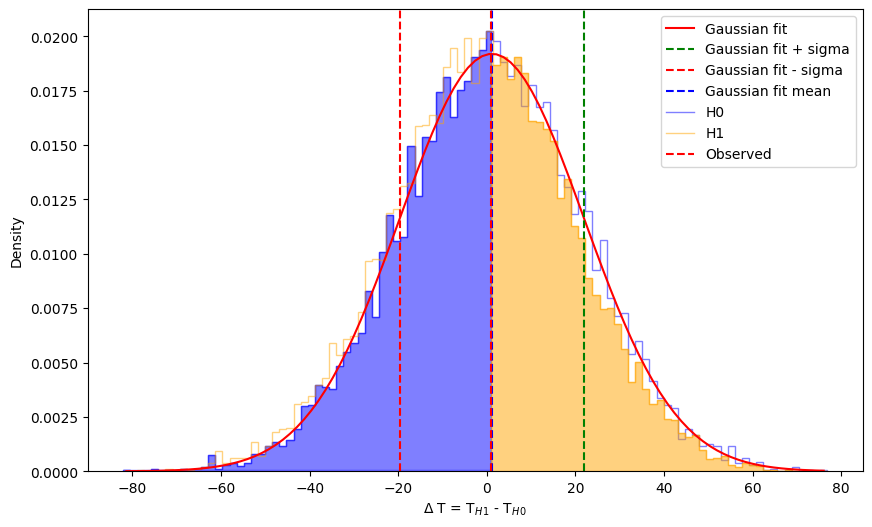

exp_cls: 0.8729235880398672, exp_cls_up: 0.9513674197384068, exp_cls_down: 0.7829727843684583


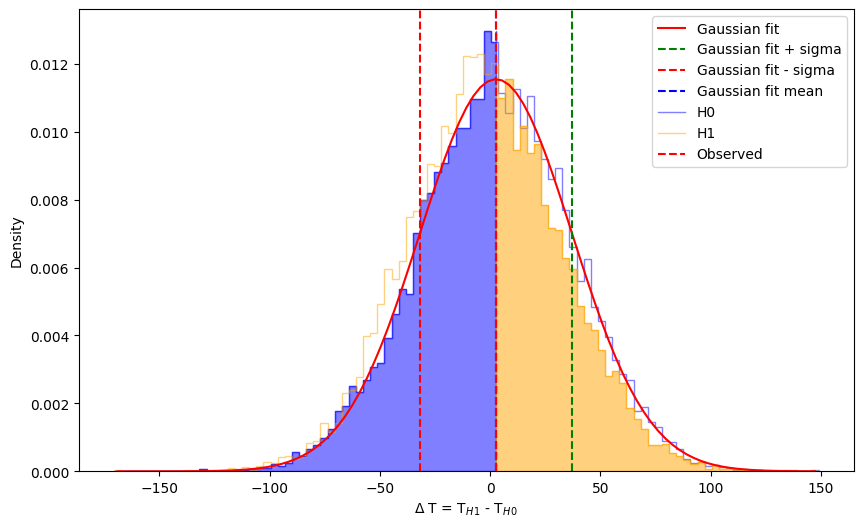

exp_cls: 0.7708681135225371, exp_cls_up: 0.8966395729710056, exp_cls_down: 0.6274887604367367


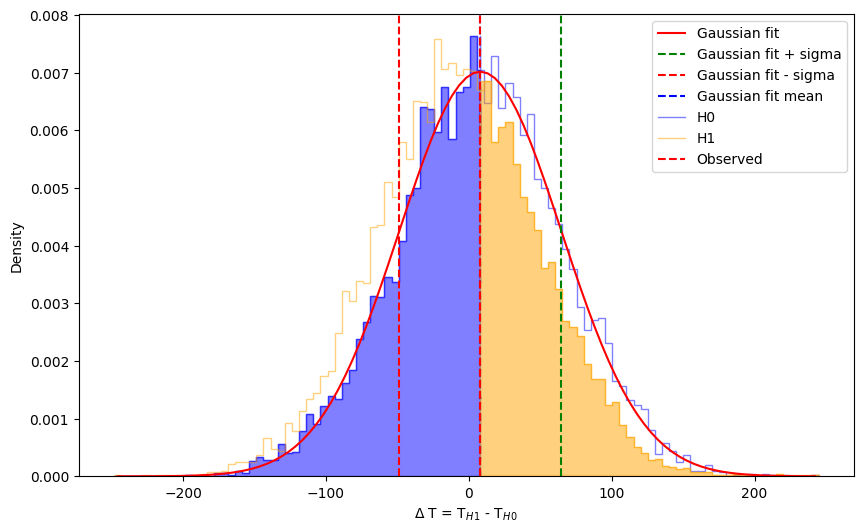

exp_cls: 0.6343076594836784, exp_cls_up: 0.8309825484102321, exp_cls_down: 0.4235537190082651


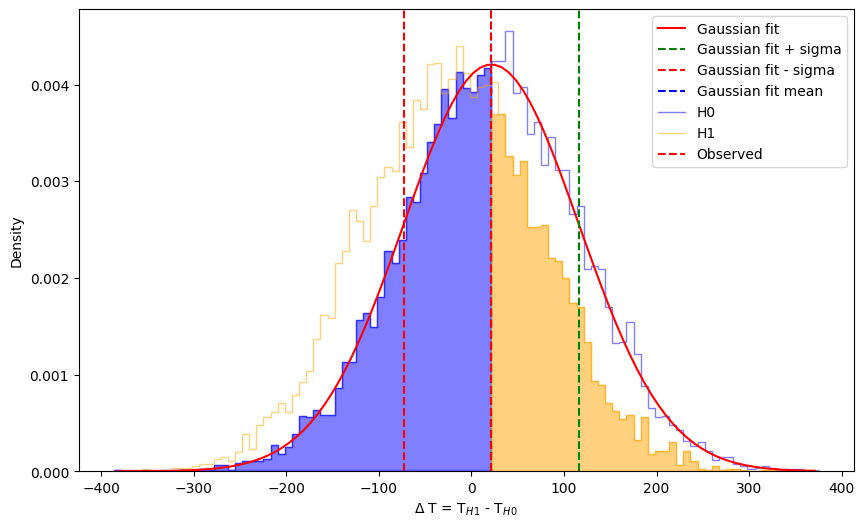

exp_cls: 0.45169545745361483, exp_cls_up: 0.7219773674806432, exp_cls_down: 0.259676284306826


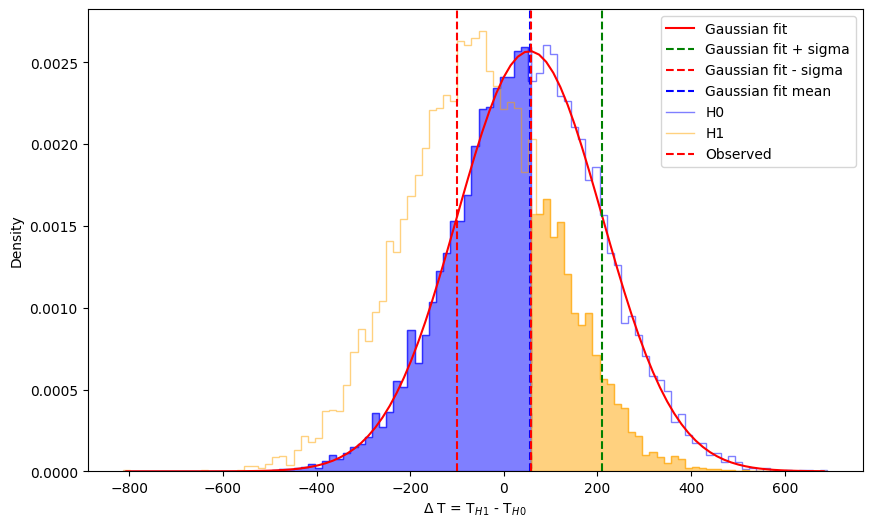

exp_cls: 0.21699856292342426, exp_cls_up: 0.45882637044192226, exp_cls_down: 0.08728179551122195


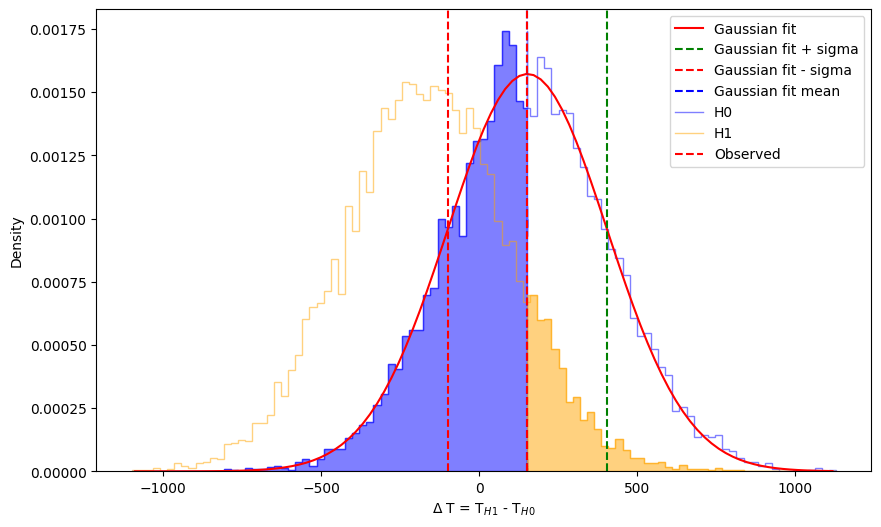

exp_cls: 0.05298416565164429, exp_cls_up: 0.18492571566614313, exp_cls_down: 0.00949598246895546


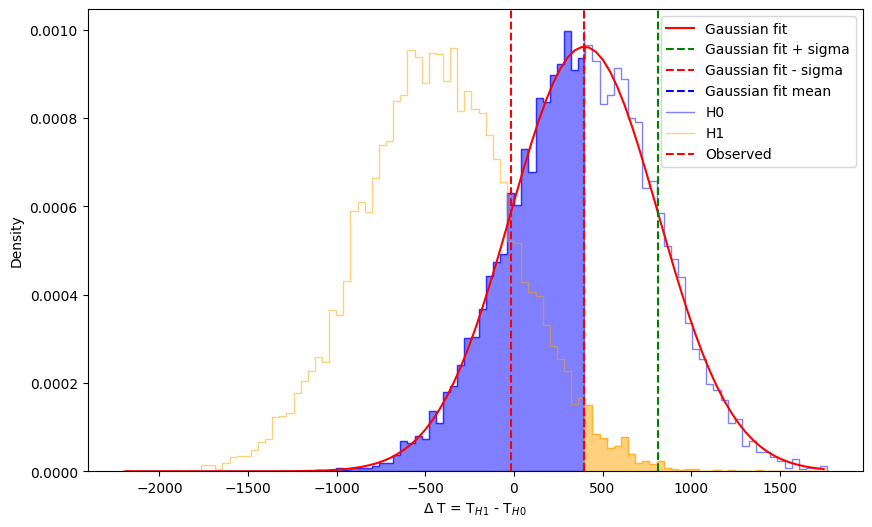

exp_cls: 0.0023830155979202732, exp_cls_up: 0.022471910112359557, exp_cls_down: 0.0


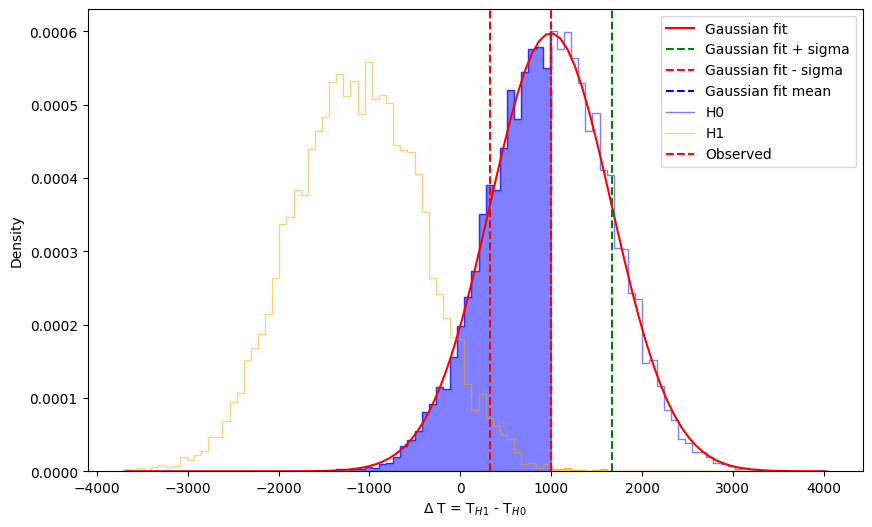

exp_cls: 0.0, exp_cls_up: 0.00024035572647518365, exp_cls_down: 0.0


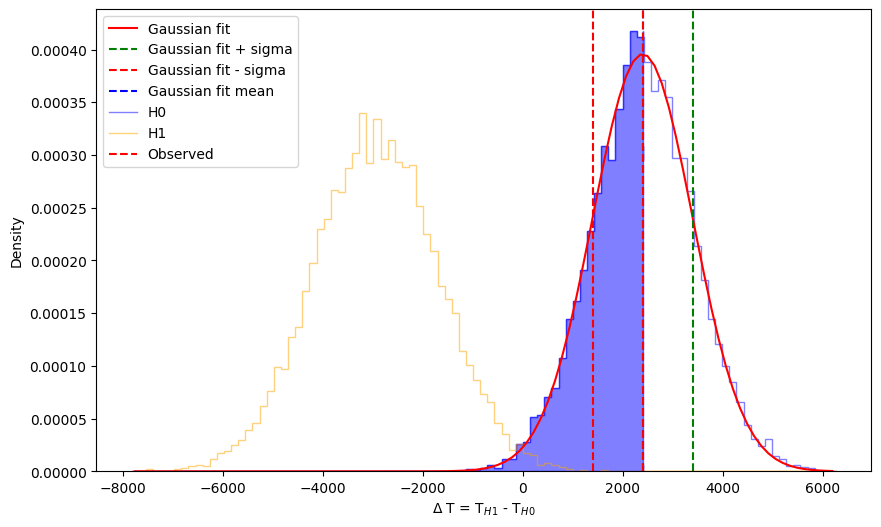

exp_cls: 0.0, exp_cls_up: 0.0, exp_cls_down: 0.0


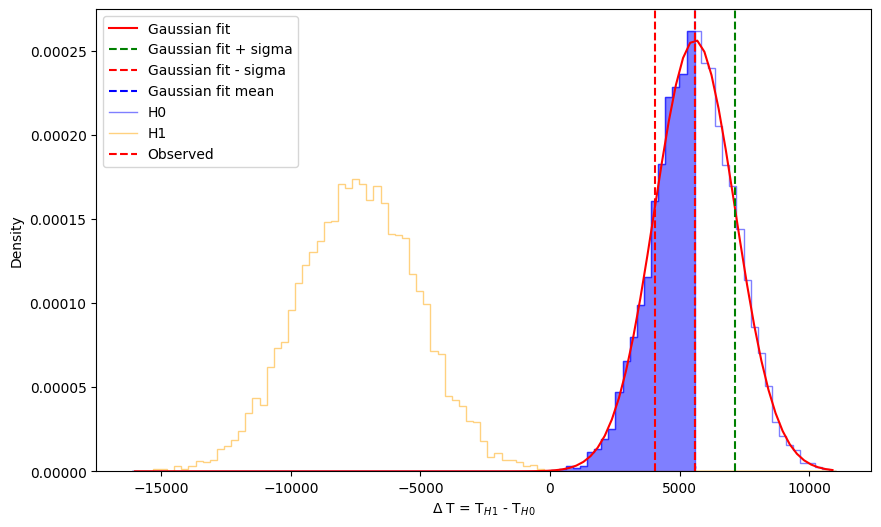

In [35]:

sf = 0.01

exp_limits = []
sf_arr = np.logspace(-3,-1, 10)

for sf in sf_arr:
    s = np.array([36296.1, 29589.2, 13971.9, 17715.2]) * sf
    s_uncert = s * 0.25
    b = np.array([254.8+3570.9+2538.1, 203.5+2038.3+2005.3, 36.6+1176.3+348.6, 22.7+377.1+218.6] )
    b_uncert = b * 0.2


    # Use either observed data or expected background
    obs = [6280, 4239, 1454, 623]
    obs = b


    n_uni = 10000

    h0_arr = []
    h1_arr = []
    for i in range(n_uni):
        h1_asi = np.random.normal(loc=s+b, scale=np.sqrt(s_uncert**2 + b_uncert**2))
        h0_asi = np.random.normal(loc=b, scale=b_uncert)

        deltaT_h0 = T_h(h0_asi, s+b) - T_h(h0_asi, b)
        deltaT_h1 = T_h(h1_asi, s+b) - T_h(h1_asi, b)

        h0_arr.append(deltaT_h0)
        h1_arr.append(deltaT_h1)

    deltaT_obs = T_h(obs, s+b) - T_h(obs, b)
    h0_arr = np.array(h0_arr)
    h0_arr = h0_arr[~np.isnan(h0_arr)]

    h1_arr = np.array(h1_arr)
    h1_arr = h1_arr[~np.isnan(h1_arr)]

    lo_T = np.min([np.min(h0_arr), np.min(h1_arr)])
    hi_T = np.max([np.max(h0_arr), np.max(h1_arr)])

    hist_bins = np.linspace(lo_T, hi_T, 100)
    hist_h0, _ = np.histogram(h0_arr, bins=hist_bins, density=True)
    hist_h1, _ = np.histogram(h1_arr, bins=hist_bins, density=True)



    bin_centers = 0.5*(hist_bins[1:] + hist_bins[:-1])
    plt.figure(figsize=(10, 6))

    A_start = np.max(hist_h0)
    H_start = np.median(h0_arr)
    parameters, covariance = curve_fit(gauss, bin_centers, hist_h0, p0=[A_start, H_start, np.std(h0_arr)], maxfev=10000)

    plt.plot(bin_centers, gauss(bin_centers, *parameters), label='Gaussian fit', color='red')
    plt.axvline(parameters[1] + parameters[2], color='g', linestyle='--', label='Gaussian fit + sigma')
    plt.axvline(parameters[1] - parameters[2], color='red', linestyle='--', label='Gaussian fit - sigma')
    plt.axvline(parameters[1], color='blue', linestyle='--', label='Gaussian fit mean')

    p_b = np.sum(hist_h0[hist_bins[:-1] < deltaT_obs]) / np.sum(hist_h0)
    p_sb = np.sum(hist_h1[hist_bins[:-1] > deltaT_obs]) / np.sum(hist_h1)
    exp_cls = p_sb / (1 - p_b)

    p_b = np.sum(hist_h0[hist_bins[:-1] < parameters[1] + parameters[2]]) / np.sum(hist_h0)
    p_sb = np.sum(hist_h1[hist_bins[:-1] > parameters[1] + parameters[2]]) / np.sum(hist_h1)
    exp_cls_down = p_sb / (1 - p_b)

    p_b = np.sum(hist_h0[hist_bins[:-1] < parameters[1] - parameters[2]]) / np.sum(hist_h0)
    p_sb = np.sum(hist_h1[hist_bins[:-1] > parameters[1] - parameters[2]]) / np.sum(hist_h1)
    exp_cls_up = p_sb / (1 - p_b)

    p_b = np.sum(hist_h0[hist_bins[:-1] < parameters[1] + 2*parameters[2]]) / np.sum(hist_h0)
    p_sb = np.sum(hist_h1[hist_bins[:-1] > parameters[1] + 2*parameters[2]]) / np.sum(hist_h1)
    exp_cls_2sigma_down = p_sb / (1 - p_b)

    p_b = np.sum(hist_h0[hist_bins[:-1] < parameters[1] - 2*parameters[2]]) / np.sum(hist_h0)
    p_sb = np.sum(hist_h1[hist_bins[:-1] > parameters[1] - 2*parameters[2]]) / np.sum(hist_h1)
    exp_cls_2sigma_up = p_sb / (1 - p_b)

    print(f'exp_cls: {exp_cls}, exp_cls_up: {exp_cls_up}, exp_cls_down: {exp_cls_down}')

    plt.stairs(hist_h0, hist_bins, label='H0', color='blue', alpha=0.5)
    plt.fill_betweenx(np.append(hist_h0, hist_h0[-1]), hist_bins, deltaT_obs, where=hist_bins < deltaT_obs, step='pre', color='blue', alpha=0.5)
    plt.stairs(hist_h1, hist_bins, label='H1', color='orange', alpha=0.5)
    plt.fill_betweenx(np.append(hist_h1, hist_h1[-1]), hist_bins, deltaT_obs, where=hist_bins > deltaT_obs, step='pre', color='orange', alpha=0.5)
    plt.axvline(deltaT_obs, color='r', linestyle='--', label='Observed')
    plt.xlabel(r'$\Delta$ T = T$_H$$_1$ - T$_H$$_0$')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    exp_limits.append([exp_cls, exp_cls_up, exp_cls_down, exp_cls_2sigma_up, exp_cls_2sigma_down])
exp_limits = np.array(exp_limits)

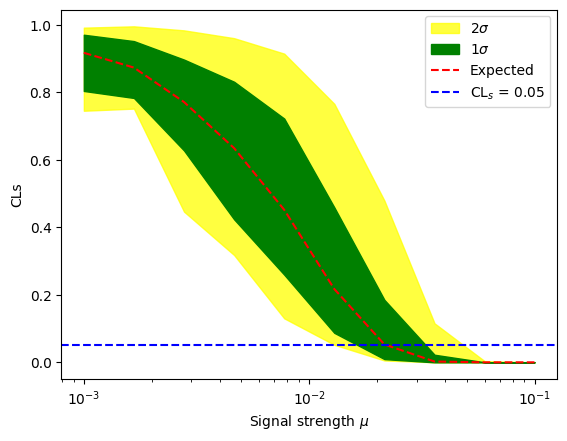

95% CLs limits
Expected limit at 95% CL: 0.05 + 0.02 - 0.09


In [36]:

plt.fill_between(sf_arr, [x[4] for x in exp_limits], [x[3] for x in exp_limits], color='yellow', alpha=0.75, label='2$\sigma$')
plt.fill_between(sf_arr, [x[2] for x in exp_limits], [x[1] for x in exp_limits], color='green', alpha=1, label='1$\sigma$')
plt.plot(sf_arr, [x[0] for x in exp_limits], label='Expected', color='red', linestyle='--')
plt.xscale('log')
plt.axhline(y=0.05, color='b', linestyle='--', label=r'CL$_s$ = 0.05')
plt.xlabel(r'Signal strength $\mu$')
plt.ylabel(r'CLs')
plt.legend()
plt.show()

print("95% CLs limits")
cls_thresh = 0.9
alpha = 1 - cls_thresh

exp_cls = exp_limits[:,0][exp_limits[:,0] < alpha][0]
exp_cls_up = exp_limits[:,1][exp_limits[:,1] < alpha][0]
exp_cls_down = exp_limits[:,2][exp_limits[:,2] < alpha][0]
exp_cls_2sigma_up = exp_limits[:,3][exp_limits[:,3] < alpha][0]
exp_cls_2sigma_down = exp_limits[:,4][exp_limits[:,4] < alpha][0]

print(f"Expected limit at 95% CL: {exp_cls:.2f} + {exp_cls_up:.2f} - {exp_cls_down:.2f}")